In [2]:
import neuron
# in the line below insert the directory for the folder where you store NEURON_mechanism
import os
usr_nm = os.path.expanduser('~')
neuron.load_mechanisms('usr_nm+/Documents/NEURON_mechanism/')
from neuron import h, gui
import numpy as np
# %matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import find_peaks
from scipy import stats
from scipy.stats import gaussian_kde
import random 
import time
from sklearn.linear_model import LinearRegression

NEURON mechanisms not found in ~/Documents/NEURON_mechanism/.


In [2]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)
plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
run general_fun.ipynb

In [5]:
h.xopen("MG_reconstructed_by_Nate_Sawtell");

len_seg = 30
for sec in h.all:
    sec.nseg = np.int32(np.ceil(sec.L/len_seg))
    if not (sec.nseg % 2):
        sec.nseg = sec.nseg + 1
        
vml_thresh = 100
h.distance(sec=h.soma)

vml = h.SectionList()
dml = h.SectionList()
exclude_comp = ['apic[0]']
for sec in h.apical:
    if sec.hname() not in exclude_comp:
        dist_from_soma = h.distance(sec(.5))
        if dist_from_soma < vml_thresh:
            vml.append(sec=sec)
        elif dist_from_soma >= vml_thresh:
            dml.append(sec=sec)

apic_soma = h.SectionList()  
for sec in h.apical:
    apic_soma.append(sec=sec)
for sec in h.somatic:
    apic_soma.append(sec=sec)
        
h.celsius = 20
set_init = -65
h.v_init = set_init

spe_cond = 0.0003
capac = 1
# insert channels

for sec in h.all:
    sec.Ra = 100    # Axial resistance in Ohm * cm
    sec.cm = capac      # Membrane capacitance in micro Farads / cm^2
for sec in h.basal:
        sec.insert('pas')
        sec.g_pas = spe_cond
        sec.e_pas = set_init

In [6]:
def make_bse(TTX = False, TTX_axon = False, TTX_apical = False, set_init = -65):

    axon_no_hh = ['axon[0]']
    for sec in h.axonal:
        if any(word in sec.hname() for word in axon_no_hh):  

            sec.insert('hh')
            sec.gl_hh = spe_cond
            sec.el_hh = set_init
            if TTX or TTX_axon:      
                sec.gnabar_hh = 0
                sec.gkbar_hh =  0
            else:
                sec.gnabar_hh = 0.168 
                sec.gkbar_hh =  0.05  
        else:
            sec.insert('hh')
            sec.gl_hh = spe_cond
            sec.el_hh = set_init
            if TTX or TTX_axon:      
                sec.gnabar_hh = 0
                sec.gkbar_hh =  0
            else:
                sec.gnabar_hh = 4 
                sec.gkbar_hh =  0.5  

    apic_no_syn = ['apic[0]'] 
    for sec in h.apical:
        if sec.hname() in apic_no_syn:
            sec.insert('pas')
            sec.g_pas = spe_cond
            sec.e_pas = set_init
        else:  
            sec.insert('hh')
            sec.gl_hh = spe_cond
            sec.el_hh = set_init  
            if TTX or TTX_apical: 
                sec.gnabar_hh = 0
                sec.gkbar_hh =  0
            else:
                sec.gnabar_hh = 0.1  
                sec.gkbar_hh =  0.008    


In [7]:
make_bse(TTX = False, TTX_axon = False, TTX_apical = False, set_init = -65)

In [8]:
def run_sim(trial_length = 100, Inh = False, pf_exc_canc_inh = False, Nspk_up_Bspk_down = False,\
            Inh_gmax = 0.04, somatic_inh = False, apical_inh = False, canc_gmax = .00022, stim_dur = 5000, record_conduc = False,\
           continuous_sensory = False, can_opposite = False):


    stim = []
    stim_all = []
    skip_every = 20*0.025
    dt = 0.025
    ampl_noise = 1/(np.sqrt(dt/4))*np.random.normal(0, .0057, int(stim_dur/skip_every)+1)
    ampl_noise[0:200] = 0
    idx = 1;
    for i in np.arange(0,stim_dur,skip_every):
        stim = h.IClamp(h.soma(0.5))
        stim.delay = i
        stim.dur = skip_every
        stim.amp = ampl_noise[idx]
        idx = idx+1
        stim_all.append(stim)
        
    if continuous_sensory:
        if Inh:    
            gaba = []
            gaba_all = [] 
            exclude_comp = ['dend[0]']
            for sec in h.dend:
                if sec.hname() not in exclude_comp:
                    for ii in np.arange(10,stim_dur,10):
                        gaba = h.GabaASyn(sec(0.45)) 
                        gaba.onset = ii + np.random.normal(0, 5, 1) 
                        gaba.gmax = Inh_gmax + .001*np.random.normal(1, 1, 1) # 0.09 
                        gaba_all.append(gaba)
                
        if pf_exc_canc_inh: 
            ampaAB = []
            ampaAB_all = []
            exclude_comp = ['apic[0]']
            for sec in h.apical:
                if sec.hname() not in exclude_comp:
   
                    for ii in np.arange(10,stim_dur,10):
                        ampa_AB = h.AmpaSyn(sec(0.5))  
                        ampa_AB.onset = ii + np.random.normal(0, 5, 1) # + np.random.normal(1, 3, 1) (0.2, 3, 1)
                        ampa_AB.gmax = canc_gmax + .00002*np.random.normal(1, 2, 1) # .00021 + .00002*np.random.normal(1, 2, 1)
                        ampaAB_all.append(ampa_AB)

        if Nspk_up_Bspk_down:
            gaba = []
            gaba_all = []    
            exclude_comp = ['dend[0]']
            for sec in h.dend:
                if sec.hname() not in exclude_comp:
                    for ii in np.arange(10,stim_dur,10):
                        gaba = h.GabaASyn(sec(0.45)) 
                        gaba.onset = ii + np.random.normal(0, 5, 1) 
                        gaba.gmax = 0.18 + .001*np.random.normal(1, 1, 1) # 0.09 
                        gaba_all.append(gaba)
                    
            ampaABE = []
            ampaABE_all = []
            for sec in h.dend:
                for ii in np.arange(10,stim_dur,10):
                    ampa_ABE = h.AmpaSyn(sec(0.5)) 
                    ampa_ABE.onset = ii + np.random.normal(0, 5, 1)
                    ampa_ABE.gmax = 0.001 + .00001*np.random.normal(1, 1, 1) #+ .01*np.random.normal(0, 1, 1)   #0.013
                    ampaABE_all.append(ampa_ABE)
                    
            if can_opposite:
                ampaAB = []
                ampaAB_all = []
                exclude_comp = ['apic[0]']
                for sec in h.apical:
                    if sec.hname() not in exclude_comp:
                        for ii in np.arange(10,stim_dur,10):
                            ampa_AB = h.AmpaSyn(sec(0.5))  
                            ampa_AB.onset = ii + np.random.normal(0, 5, 1) # + np.random.normal(1, 3, 1) (0.2, 3, 1)
                            ampa_AB.gmax = canc_gmax 
                            ampaAB_all.append(ampa_AB)

                    
        if somatic_inh:    
            gaba = []
            gaba_all = []
            for ii in np.arange(10,stim_dur,10):
                gaba = h.GabaASyn(h.soma(0.4))
                gaba.onset = ii + np.random.normal(0, 5, 1) 
                gaba.gmax = Inh_gmax + .001*np.random.normal(1, 1, 1) # 0.09 
                gaba_all.append(gaba)
        
        if apical_inh:   
            gaba = []
            gaba_all = [] 
            exclude_comp = ['apic[0]']
            for sec in vml:
                if sec.hname() not in exclude_comp:
                    for ii in np.arange(10,stim_dur,10):
                        gaba = h.GabaASyn(sec(0.45)) 
                        gaba.onset = ii + np.random.normal(0, 5, 1) 
                        gaba.gmax = Inh_gmax + .001*np.random.normal(1, 1, 1) # 0.09 
                        gaba_all.append(gaba)
#######             
    else:
        if Inh:    
            gaba = []
            gaba_all = [] 
            for sec in vml:
                for ii in np.arange((trial_length/2-3),stim_dur,trial_length):
                    gaba = h.GabaASyn(sec(0.45)) 
                    gaba.onset = ii + np.random.normal(0, 5, 1) 
                    gaba.gmax = Inh_gmax + .001*np.random.normal(1, 1, 1) # 0.09 
                    gaba_all.append(gaba)

        if pf_exc_canc_inh: 
            ampaAB = []
            ampaAB_all = []
            exclude_comp = ['apic[0]']
            for sec in h.apical:
                if sec.hname() not in exclude_comp:   
                    for ii in np.arange((trial_length/2-3),stim_dur,trial_length):
                        ampa_AB = h.AmpaSyn(sec(0.5))  
                        ampa_AB.onset = ii + np.random.normal(0, 5, 1) # + np.random.normal(1, 3, 1) (0.2, 3, 1)
                        ampa_AB.gmax = canc_gmax + .00002*np.random.normal(1, 2, 1) # .00021 + .00002*np.random.normal(1, 2, 1)
                        ampaAB_all.append(ampa_ABE)
######
        if Nspk_up_Bspk_down:
            gaba = []
            gaba_all = []    
            for sec in vml:
                for ii in np.arange((trial_length/2-3),stim_dur,trial_length):
                    gaba = h.GabaASyn(sec(0.45)) 
                    gaba.onset = ii + np.random.normal(0, 2, 1) 
                    gaba.gmax = 0.2 + .001*np.random.normal(1, 1, 1) # strong 0.05 -- small 0.025 -- Miniscule 0.01
                    gaba_all.append(gaba)

            ampaABE = []
            ampaABE_all = []  
            for ii in np.arange((trial_length/2),stim_dur,trial_length):
                ampa_ABE = h.AmpaSyn(h.dend[1](0.5)) 
                ampa_ABE.onset = ii + np.random.normal(0, 4, 1) 
                ampa_ABE.gmax = 0.02 + .001*np.random.normal(1, 1, 1) #+ .01*np.random.normal(0, 1, 1)   #0.013
                ampaABE_all.append(ampa_AB)


    dict_all = {}
    v_vec_apic = h.Vector()        
    v_vec_apic_up = h.Vector()
    v_vec_axon = h.Vector()        
    v_vec_soma = h.Vector()        
    t_vec = h.Vector()             

    v_vec_apic.record(h.apic[11](0.5)._ref_v)
    v_vec_apic_up.record(h.apic[11](1)._ref_v)
    v_vec_axon.record(h.axon[3](0.5)._ref_v)
    v_vec_soma.record(h.soma(0.5)._ref_v)
    t_vec.record(h._ref_t)
    
    if record_conduc:
        ina_vec_apic = h.Vector()        
        ik_vec_apic = h.Vector() 
        m_vec_apic = h.Vector()        
        h_vec_apic = h.Vector() 
        n_vec_apic = h.Vector() 

        ina_vec_apic.record(h.apic[11](1)._ref_ina)
        ik_vec_apic.record(h.apic[11](1)._ref_ik)
        m_vec_apic.record(h.apic[11](1)._ref_m_hh)
        h_vec_apic.record(h.apic[11](1)._ref_h_hh)
        n_vec_apic.record(h.apic[11](1)._ref_n_hh)

    h.tstop = stim_dur
    h.run()
    dict_all['t_vec'] =  t_vec
    dict_all['v_vec_apic'] = v_vec_apic
    dict_all['v_vec_apic_up'] = v_vec_apic_up
    dict_all['v_vec_axon'] = v_vec_axon
    dict_all['v_vec_soma'] = v_vec_soma
    
    if record_conduc:
        dict_all['ina_vec_apic'] = ina_vec_apic        
        dict_all['ik_vec_apic'] = ik_vec_apic 
        dict_all['m_vec_apic'] = m_vec_apic        
        dict_all['h_vec_apic'] = h_vec_apic 
        dict_all['n_vec_apic'] = n_vec_apic 

    stim = []
    stim_all = []

    ampaA = []
    ampaA_all = []

    ampaAAB = []
    ampaAAB_all = []

    gaba = []
    gaba_all = []

    ampaAB = []
    ampaAB_all = []

    ampaABE = []
    ampaABE_all = []

    return dict_all

In [9]:
def plot_spikes(data,ylim_nspk = [0,100]):
    shape_data = np.shape(data)
    data_to_analyze = [np.hstack(data)]
    spk_times_soma = turn_trace_to_spk(data_to_analyze, min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                          prom_nspk = 3, prom_bspk = 25)
    spk_rates_soma = make_shaped_spk_rate(spk_times_soma, shape_data, Method = 'wrap',Nspk_time_ms = 5, Bspk_time_ms = 8)


    bins_ms = 5 #ms
    nr_iter = len(data)
    bin_Nspk = bin_data(spk_rates_soma['Nspk_number'],eliminate_trials = 0,trial_length = bins_ms)
    bin_Bspk = bin_data(spk_rates_soma['Bspk_number'],eliminate_trials = 0,trial_length = bins_ms)

    fs = 12
    ts = 12

    %matplotlib osx
    fig = plt.figure(figsize=(12,7)) # Default figsize is (8,6)
    plt.rc('xtick',labelsize=fs)
    plt.rc('ytick',labelsize=fs)

    plt.subplot(2,3,3)
    rnd_num = np.random.randint(0,len(data),2);
    for ii in rnd_num:
        print(ii)
        plt.plot(data[ii])
    locs, labels = plt.xticks()
    dt = 0.025
    ticknames = np.require(locs*dt,dtype=int)
    plt.xticks(locs, ticknames)
    plt.ylabel('trace (mV)', fontsize=fs)
    plt.xlabel('time (ms)', fontsize=fs)
    plt.title('sample traces', fontsize=ts)
    plt.ylim([-80,0])
    plt.xlim([-5/dt,(trial_length+5)/dt])

    plt.subplot(2,3,6)
    rnd_num = np.random.randint(0,len(data),2);
    for ii in rnd_num:
        print(ii)
        plt.plot(data[ii])
    locs, labels = plt.xticks()
    dt = 0.025
    ticknames = np.require(locs*dt,dtype=int)
    plt.xticks(locs, ticknames)
    plt.ylabel('trace (mV)', fontsize=fs)
    plt.xlabel('time (ms)', fontsize=fs)
    plt.ylim([-80,0])
    plt.xlim([-5/dt,(trial_length+5)/dt])

    plt.subplot(2,3,1)
    plt.plot(spk_rates_soma['Nspk_rate_smoothed'],'k')
    locs, labels = plt.xticks()
    dt = 0.025
    ticknames = np.require(locs*dt,dtype=int)
    plt.xticks(locs, ticknames)
    plt.ylabel('Nspk rate (Hz)', fontsize=fs)
    plt.xlabel('time (ms)', fontsize=fs)
    plt.title('Nspk', fontsize=ts)
    plt.xlim([-5/dt,(trial_length+5)/dt])
    plt.ylim(ylim_nspk)


    plt.subplot(2,3,4)
    plt.plot(bin_Nspk/nr_iter/(bins_ms*0.001),'k')
    locs, labels = plt.xticks()
    ticknames = np.require(locs*bins_ms,dtype=int)
    plt.xticks(locs, ticknames)
    plt.ylabel('Nspk rate (Hz), bin size = {} ms'.format(bins_ms), fontsize=15)
    plt.xlabel('time (ms)',fontsize=fs)
    plt.xlim([-1,len(bin_Nspk)])
    plt.ylim(ylim_nspk)

    plt.subplot(2,3,2)
    plt.plot(spk_rates_soma['Bspk_rate_smoothed'],'r')
    locs, labels = plt.xticks()
    dt = 0.025
    ticknames = np.require(locs*dt,dtype=int)
    plt.xticks(locs, ticknames)
    plt.ylabel('Bspk rate (Hz)', fontsize=fs)
    plt.xlabel('time (ms)', fontsize=fs)
    plt.ylim([-0.5, 10])
    plt.title('Bspk', fontsize=ts)
    plt.xlim([-5/dt,(trial_length+5)/dt])

    plt.subplot(2,3,5)
    plt.plot(bin_Bspk/nr_iter/(bins_ms*0.001),'r')
    locs, labels = plt.xticks();
    ticknames = np.require(locs*bins_ms,dtype=int)
    plt.xticks(locs, ticknames)
    plt.ylabel('Bspk rate (Hz), bin size = {} ms'.format(bins_ms), fontsize=15)
    plt.xlabel('time (ms)', fontsize=fs)
    plt.ylim([-0.5,10])
    plt.xlim([-1,len(bin_Bspk)])
    
    return fig


In [26]:
def plot_summary_3_cond(data1,data2,data3,ylim_nspk = [20,120],titles = ['baseline','inhib.','cancel.']):
    fs = 6
    ts = 6

    %matplotlib osx
    fig = plt.figure(figsize=(6,2)) # Default figsize is (8,6)
    plt.rc('xtick',labelsize=fs)
    plt.rc('ytick',labelsize=fs)

    dt = 0.025

    for kk in range(3):

        if kk == 0:
            data_soma = data1
            colr = 'k'
        elif kk == 1:    
            data_soma = data2
            colr = 'r'
        elif kk == 2:    
            data_soma = data3
            colr = 'm'


        shape_data = np.shape(data_soma)
        data_to_analyze = [np.hstack(data_soma)]
        spk_times_soma = turn_trace_to_spk(data_to_analyze, min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                              prom_nspk = 3, prom_bspk = 15)
        spk_rates_soma = make_shaped_spk_rate(spk_times_soma, shape_data, Method = 'wrap',Nspk_time_ms = 5, Bspk_time_ms = 8)


        plt.subplot(1,2,1)
        plt.plot(spk_rates_soma['Bspk_rate_smoothed'],color=colr)
        locs, labels = plt.xticks()
        dt = 0.025
        ticknames = np.require(locs*dt,dtype=int)
        plt.xticks(locs, ticknames)
        plt.ylabel('broad spike rate (Hz)', fontsize=fs)
        plt.xlabel('time (ms)', fontsize=fs)
        plt.ylim([-0.5, 5])
        plt.title('broad spike', fontsize=ts)
        plt.xlim([-5/dt,(trial_length+5)/dt])
        if kk == 2:
            plt.legend(titles[0:kk+1], fontsize=fs, frameon=False)

        plt.subplot(1,2,2)
        plt.plot(spk_rates_soma['Nspk_rate_smoothed'],color=colr)
        locs, labels = plt.xticks()
        dt = 0.025
        ticknames = np.require(locs*dt,dtype=int)
        plt.xticks(locs, ticknames)
        plt.ylabel('narrow spike rate (Hz)', fontsize=fs)
        plt.xlabel('time (ms)', fontsize=fs)
        plt.title('narrow spike', fontsize=ts)
        plt.xlim([-5/dt,(trial_length+5)/dt])
        plt.ylim(ylim_nspk)
        if kk == 2:
            plt.legend(titles[0:kk+1], fontsize=fs, frameon=False)
            
    return fig

In [11]:
def plot_summary_3_cond_bg(data1,data2,data3,titles = ['baseline','inhib.','cancel.']):

    %matplotlib osx

    rate_nspk = np.zeros(4)
    rate_bspk = np.zeros(4)
    ratio_all = np.zeros(4)

    dt = 0.025

    for kk in range(3):

        if kk == 0:
            data_soma = [np.hstack(data1)]
        elif kk == 1:    
            data_soma = [np.hstack(data2)]        
        elif kk == 2:    
            data_soma = [np.hstack(data3)]
            
        spk_times_all = turn_trace_to_spk(data_soma, min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                          prom_nspk = 3, prom_bspk = 15)

        peaks_nspk_loc = spk_times_all['peaks_nspk_all']
        peaks_bspk_loc = spk_times_all['peaks_bspk_all']

        rate_nspk[kk] = len(np.concatenate(peaks_nspk_loc))/(len(data_soma[0])/(1/(dt*0.001)))
        rate_bspk[kk] = len(np.concatenate(peaks_bspk_loc))/(len(data_soma[0])/(1/(dt*0.001)))
        ratio_all[kk] = rate_bspk[kk]/rate_nspk[kk]



    fs = 6
    ts = 6
    plt.rc('xtick',labelsize=fs)
    plt.rc('ytick',labelsize=fs)

    colr = ['k','r','m']

    fig = plt.figure(figsize=(8,2))


    plt.subplot(1,3,1)
    plt.bar(titles[0:3],rate_bspk[0:3],color=colr,width = 0.5)
    plt.ylabel('rate Bspk (Hz)', fontsize = fs)
    ax = plt.gca()
    ax.fontsize = fs
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)


    plt.subplot(1,3,2)
    plt.bar(titles[0:3],rate_nspk[0:3],color=colr,align='center',width = 0.5)
    plt.ylabel('rate Nspk (Hz)', fontsize = fs)
    ax = plt.gca()
    ax.fontsize = fs
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)


    plt.subplot(1,3,3)
    plt.bar(titles[0:3],ratio_all[0:3],color=colr,width = 0.5)
    plt.ylabel('p, r(bs)/r(ns)', fontsize = fs)
    ax = plt.gca()
    ax.fontsize = fs
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)
    ax.ticklabel_format(axis='y', style='', scilimits=(-1,-1), useOffset=None, useLocale=None, useMathText=None)
    
    return fig


In [12]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

Inh = False
Inh_gmax = 0 #0.03 
pf_exc_canc_inh = False
canc_gmax = 0 #.000083
Nspk_up_Bspk_down = False
after_minus_before = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Inh = True
    Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh = Inh, Inh_gmax = Inh_gmax, pf_exc_canc_inh = pf_exc_canc_inh,\
                          canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_baseline_noise = all_runs_apic
data_baseline_noise_apic_up = all_runs_apic_up
data_baseline_noise_soma = all_runs
data_baseline_noise_axon = all_runs_axon
data_baseline_ina = all_runs_ina 
data_baseline_ik = all_runs_ik 
data_baseline_m = all_runs_m 
data_baseline_h = all_runs_h 
data_baseline_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_baseline = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_baseline = spk_times_all['peaks_bspk_all']
nspk_peak_baseline = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]

37.75779318809509


11
29
43
33


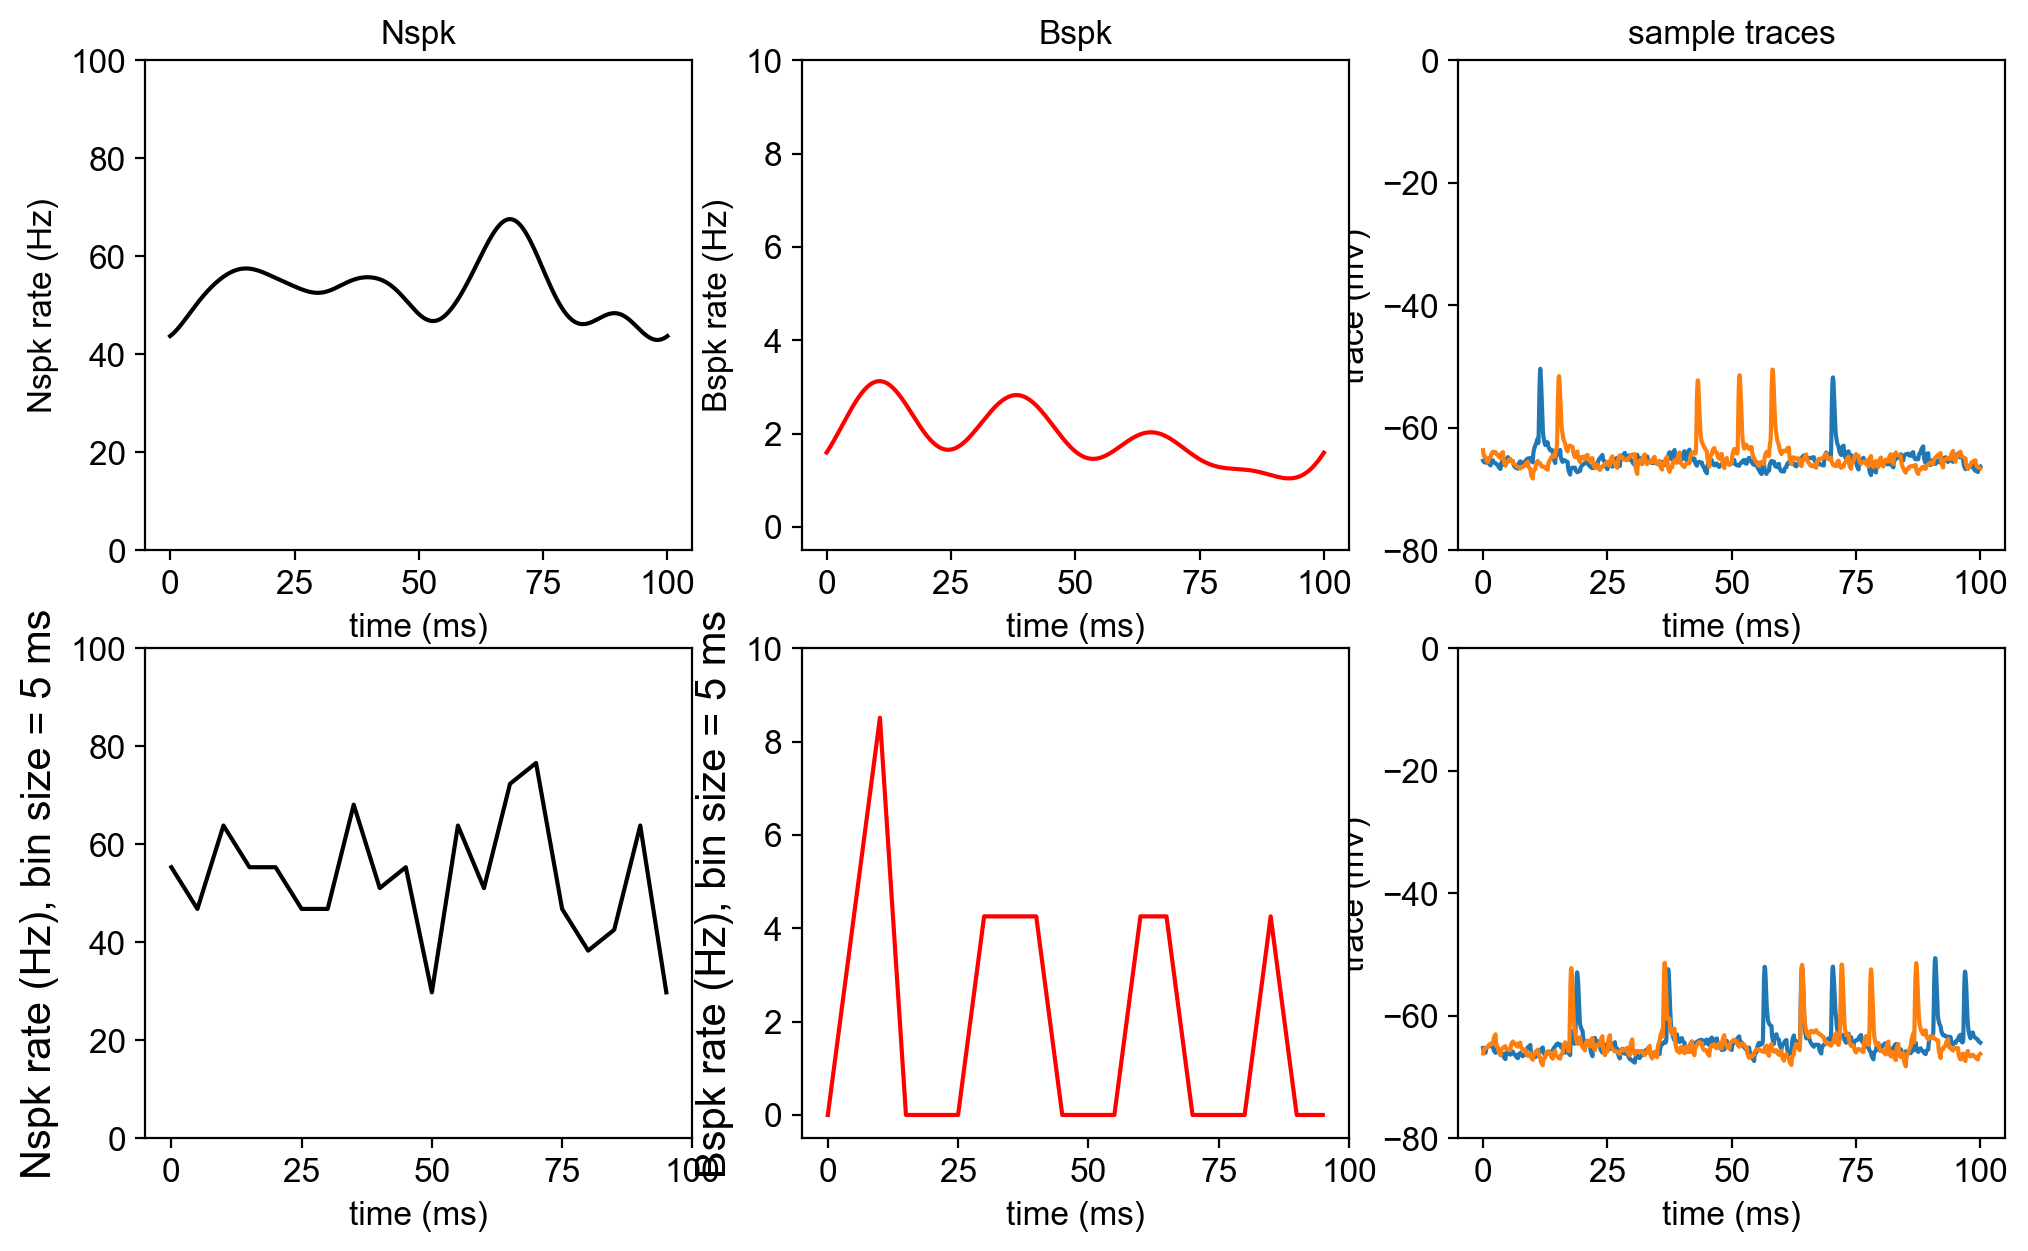

In [13]:
plot_spikes(data_baseline_noise_soma)

In [14]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

Inh = True
Inh_gmax = 0.1 #0.02
pf_exc_canc_inh = False
canc_gmax = 0 
Nspk_up_Bspk_down = False
after_minus_before = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Inh = True
    Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh = Inh, Inh_gmax = Inh_gmax, pf_exc_canc_inh = pf_exc_canc_inh,\
                          canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_inhibition_noise = all_runs_apic
data_inhibition_noise_apic_up = all_runs_apic_up
data_inhibition_noise_soma = all_runs
data_inhibition_noise_axon = all_runs_axon
data_inhibition_ina = all_runs_ina 
data_inhibition_ik = all_runs_ik 
data_inhibition_m = all_runs_m 
data_inhibition_h = all_runs_h 
data_inhibition_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_inhibition = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_inhibition = spk_times_all['peaks_bspk_all']
nspk_peak_inhibition = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]


73.7465569972992


43
40
1
35


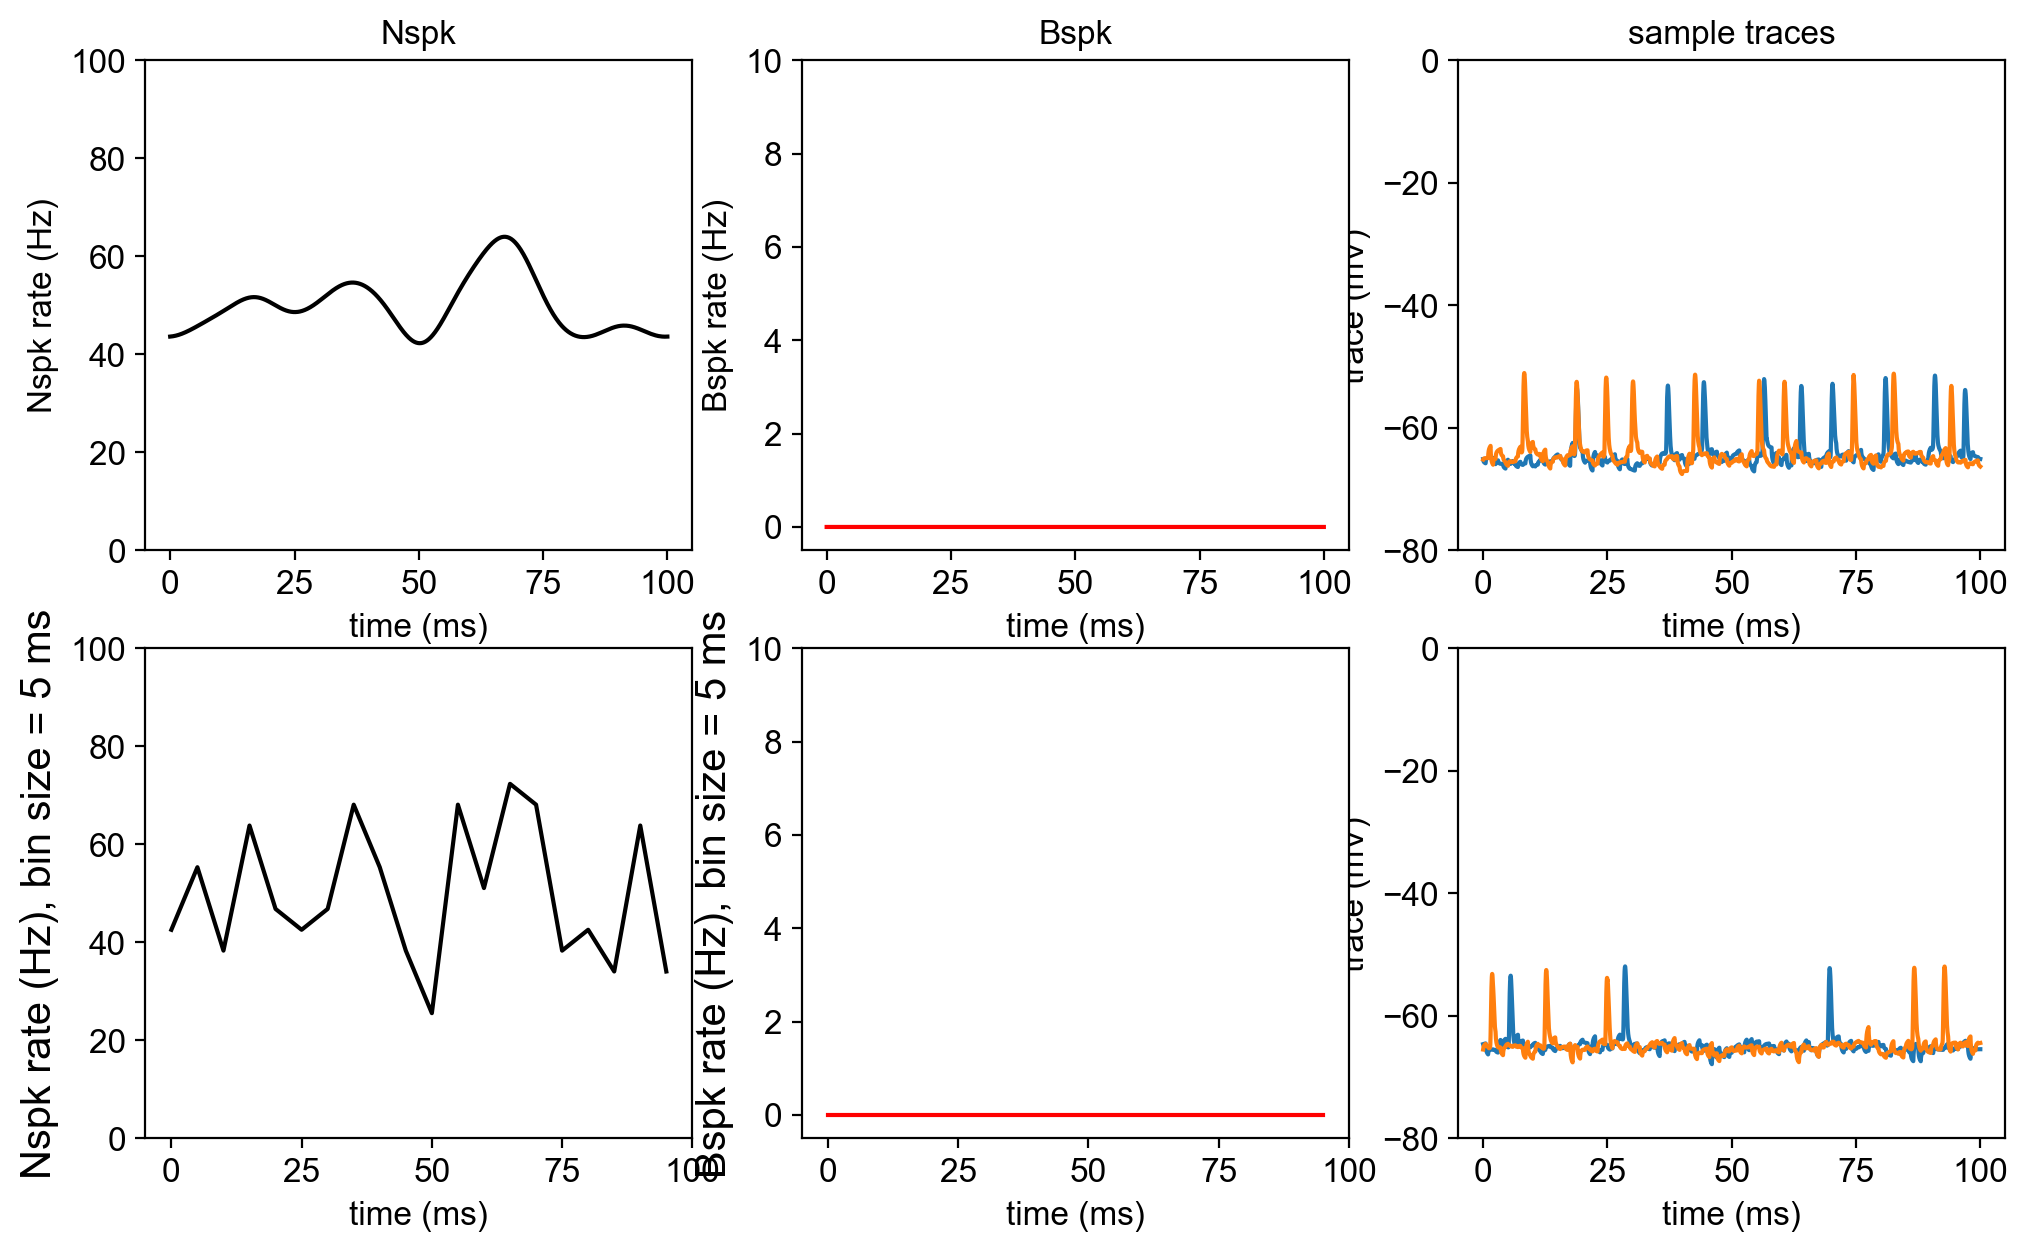

In [15]:
plot_spikes(data_inhibition_noise_soma)

In [16]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

Inh = True
Inh_gmax = 0.1 #0.02 
pf_exc_canc_inh = True
canc_gmax = .0000765 #3e-05
Nspk_up_Bspk_down = False
after_minus_before = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Inh = True
    Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh = Inh, Inh_gmax = Inh_gmax, pf_exc_canc_inh = pf_exc_canc_inh,\
                          canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_cancellation_noise = all_runs_apic
data_cancellation_noise_apic_up = all_runs_apic_up
data_cancellation_noise_soma = all_runs
data_cancellation_noise_axon = all_runs_axon
data_cancellation_ina = all_runs_ina 
data_cancellation_ik = all_runs_ik 
data_cancellation_m = all_runs_m 
data_cancellation_h = all_runs_h 
data_cancellation_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_cancellation = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_cancellation = spk_times_all['peaks_bspk_all']
nspk_peak_cancellation = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]


179.54693484306335


27
20
43
33


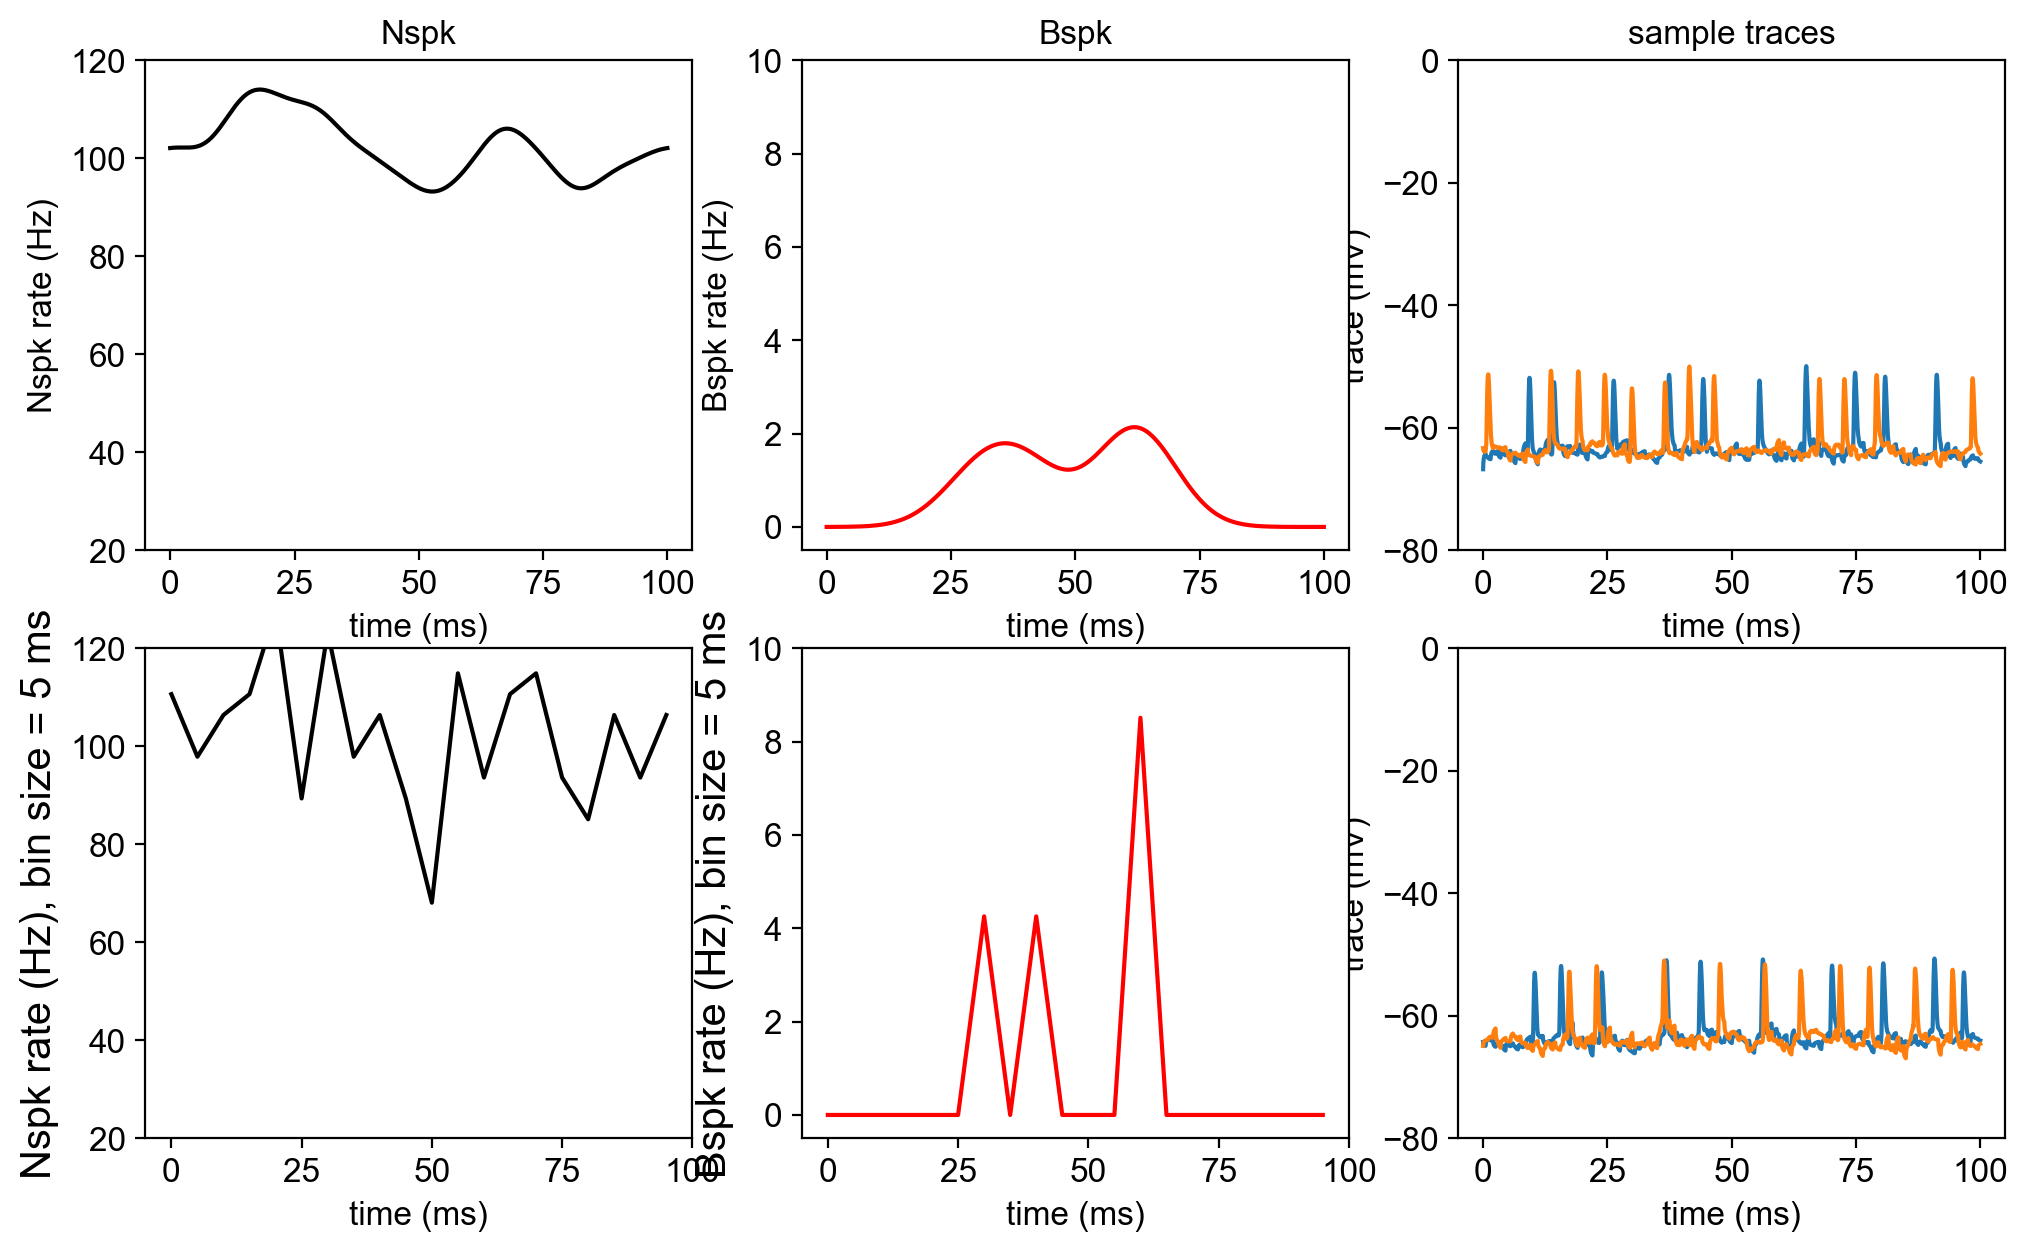

In [17]:
plot_spikes(data_cancellation_noise_soma, ylim_nspk = [20,120])


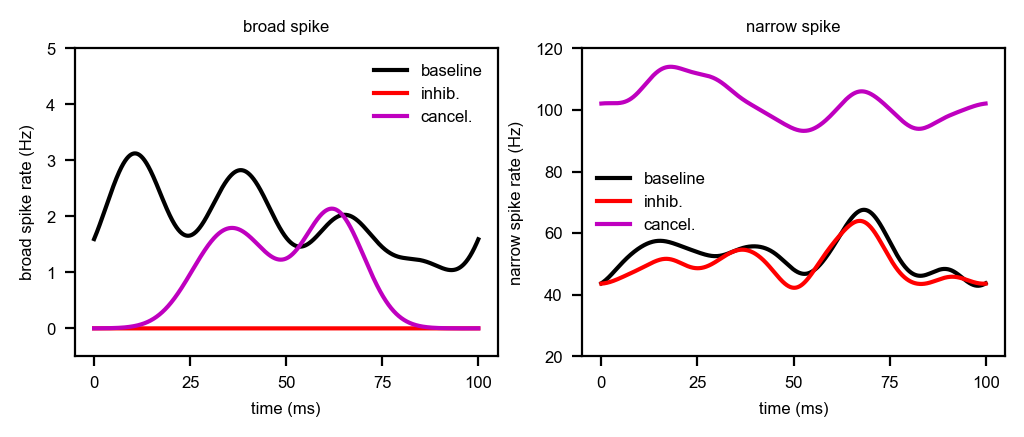

In [27]:
plot_summary_3_cond(data_baseline_noise_soma,data_inhibition_noise_soma,data_cancellation_noise_soma)    

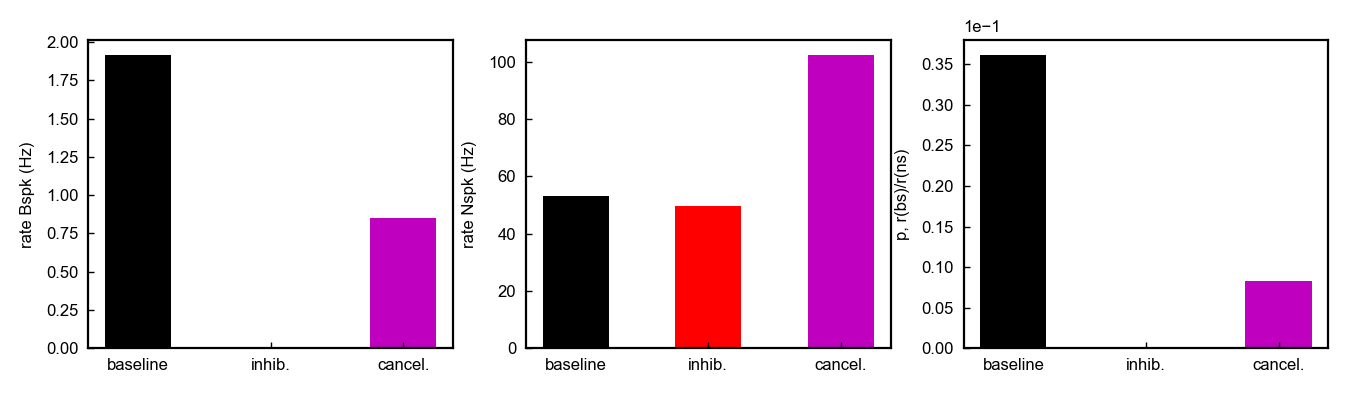

In [19]:
plot_summary_3_cond_bg(data_baseline_noise_soma,data_inhibition_noise_soma,data_cancellation_noise_soma)

# Somatic inhibition

In [28]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

somatic_inh = True
Inh_gmax = 0.04 #0.05
pf_exc_canc_inh = False
canc_gmax = 0 #.000083
Nspk_up_Bspk_down = False
after_minus_before = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Inh = True
    Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh_gmax = Inh_gmax, somatic_inh = somatic_inh,\
                          pf_exc_canc_inh = pf_exc_canc_inh,canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_soma_inh_noise = all_runs_apic
data_soma_inh_noise_apic_up = all_runs_apic_up
data_soma_inh_noise_soma = all_runs
data_soma_inh_noise_axon = all_runs_axon
data_soma_inh_ina = all_runs_ina 
data_soma_inh_ik = all_runs_ik 
data_soma_inh_m = all_runs_m 
data_soma_inh_h = all_runs_h 
data_soma_inh_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_soma_inh = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_soma_inh = spk_times_all['peaks_bspk_all']
nspk_peak_soma_inh = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]


39.599003076553345


44
42
29
24


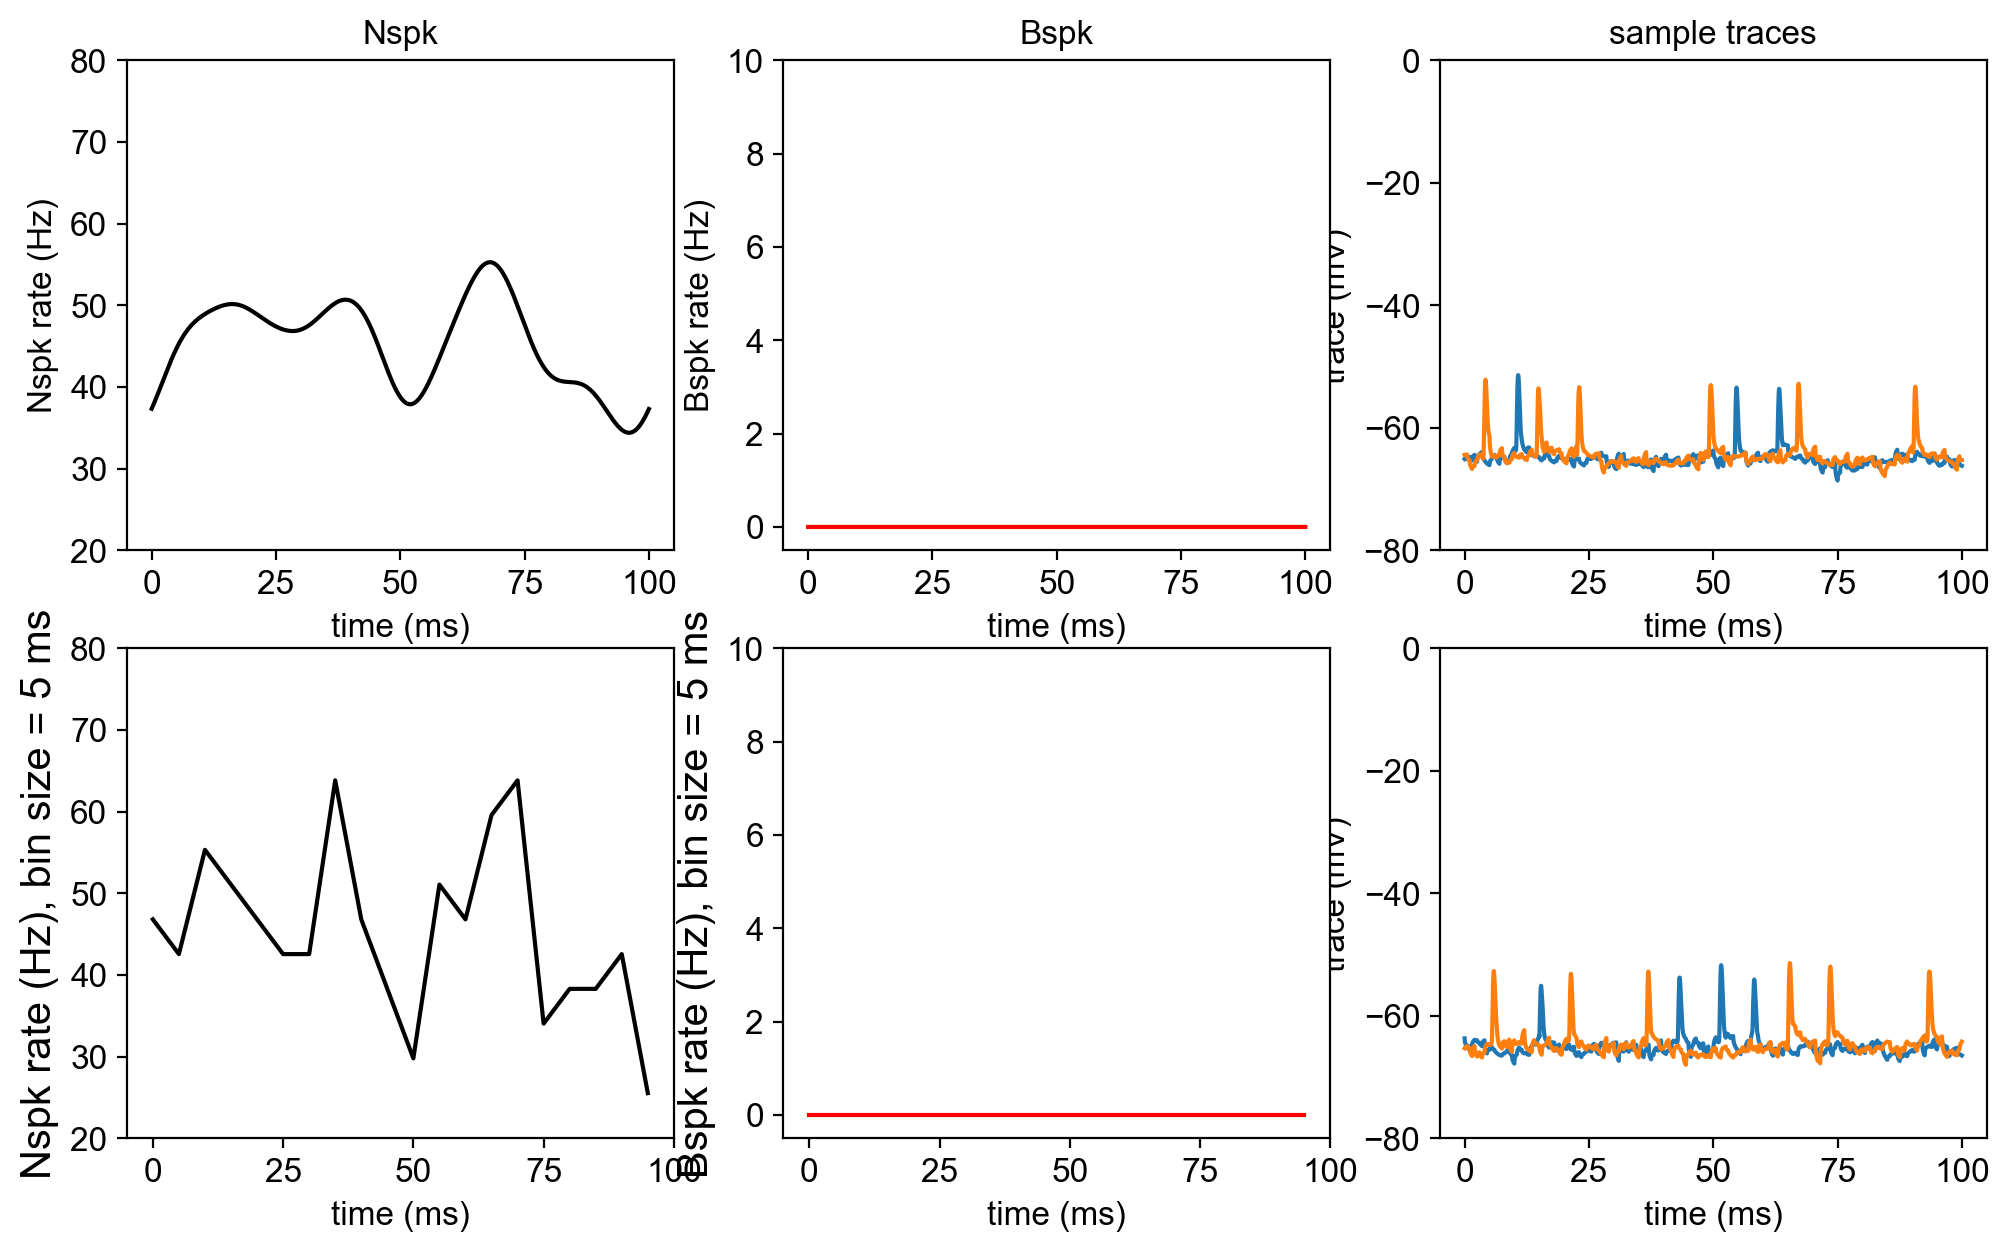

In [29]:
plot_spikes(data_soma_inh_noise_soma, ylim_nspk = [20,80])

In [30]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

somatic_inh = True
Inh_gmax = 0.04 #0.05
pf_exc_canc_inh = True
canc_gmax = 1.85e-5 #.000033
Nspk_up_Bspk_down = False
after_minus_before = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh_gmax = Inh_gmax, somatic_inh = somatic_inh,\
                          pf_exc_canc_inh = pf_exc_canc_inh,canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_soma_can_noise = all_runs_apic
data_soma_can_noise_apic_up = all_runs_apic_up
data_soma_can_noise_soma = all_runs
data_soma_can_noise_axon = all_runs_axon
data_soma_can_ina = all_runs_ina 
data_soma_can_ik = all_runs_ik 
data_soma_can_m = all_runs_m 
data_soma_can_h = all_runs_h 
data_soma_can_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_soma_can = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_soma_can = spk_times_all['peaks_bspk_all']
nspk_peak_soma_can = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]


133.20721793174744


14
6
24
6


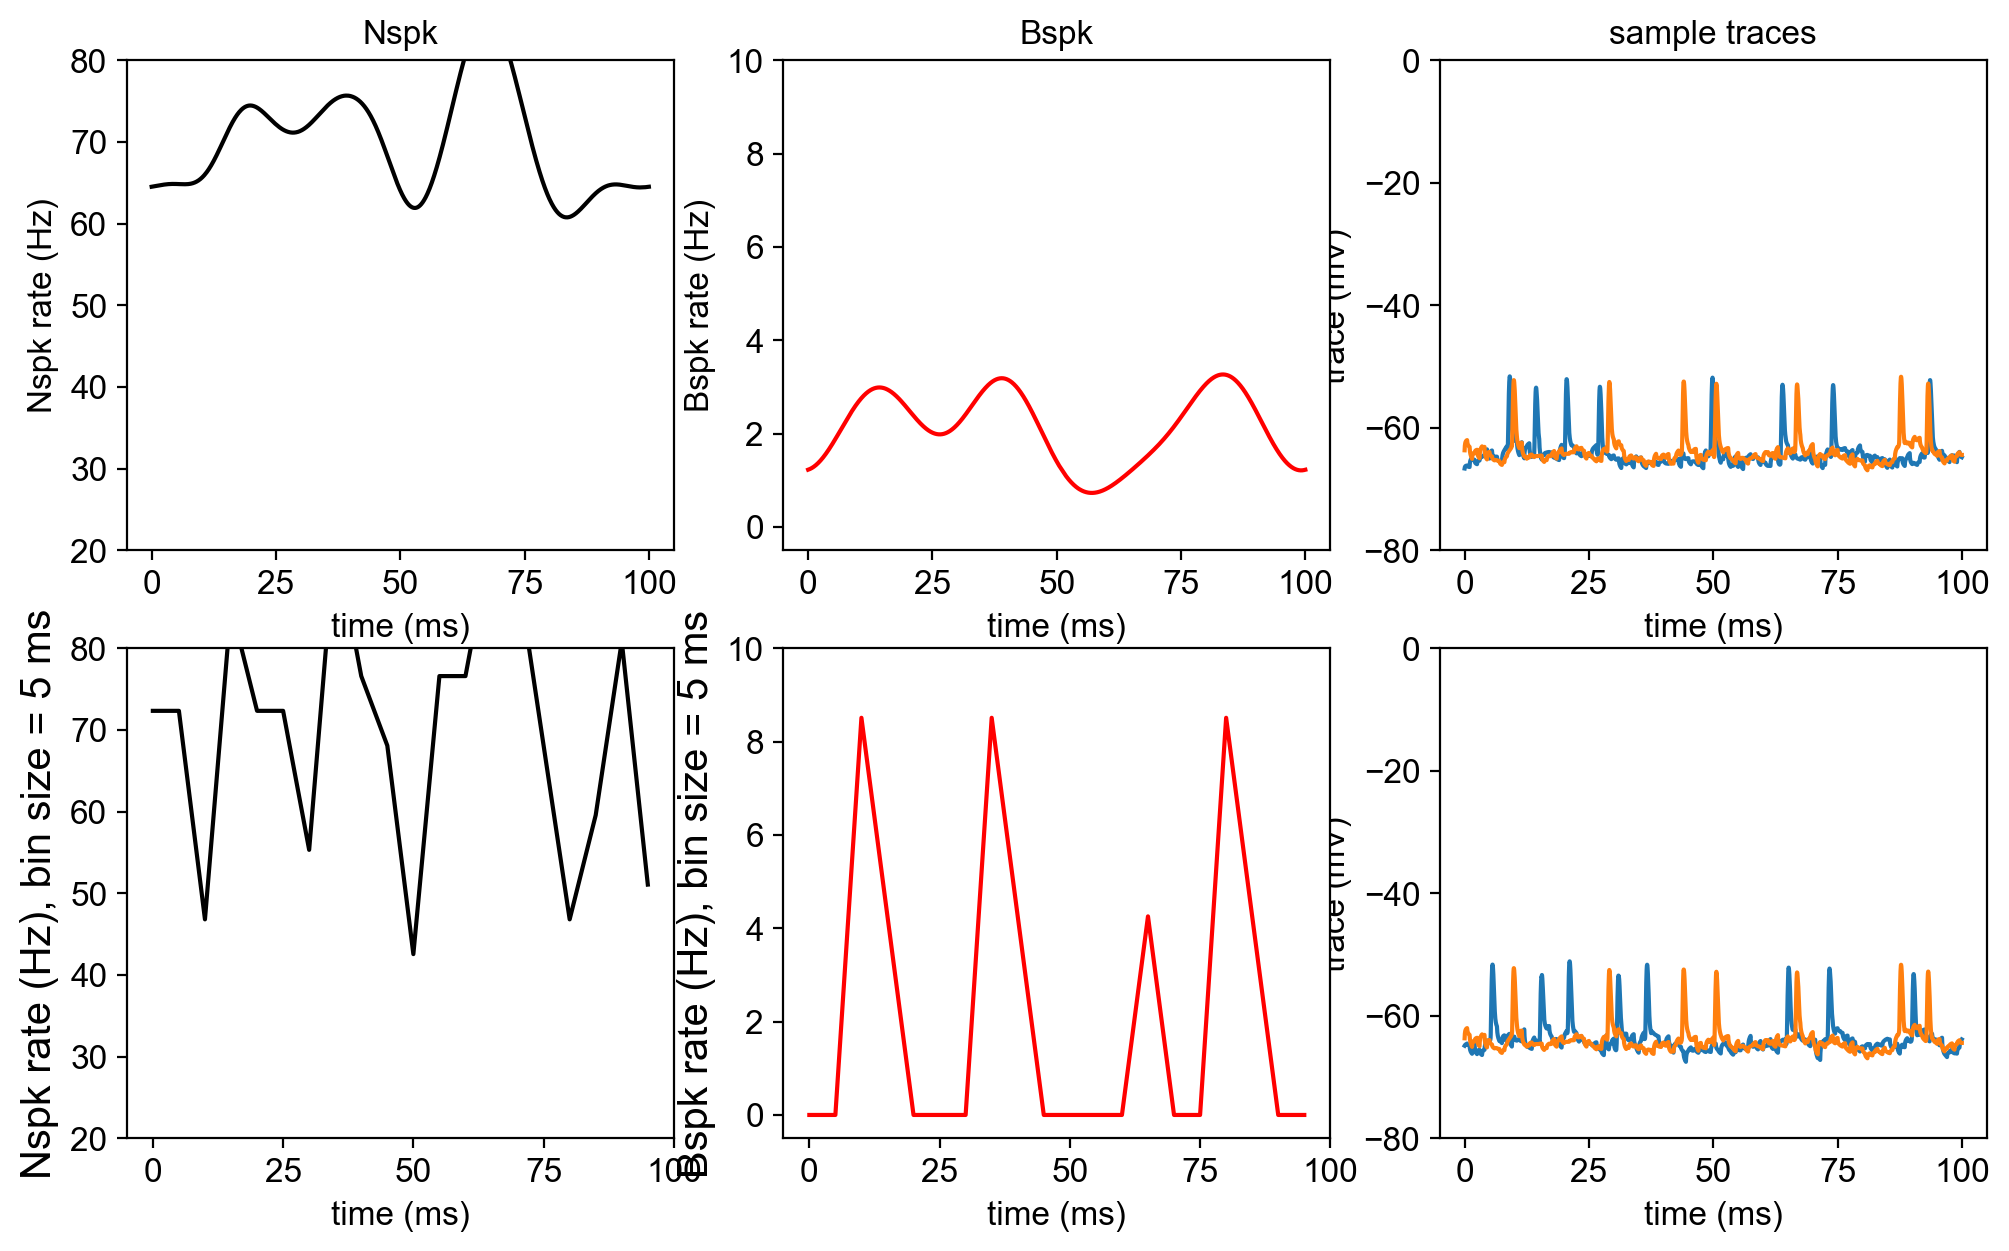

In [31]:
plot_spikes(data_soma_can_noise_soma, ylim_nspk = [20,80])


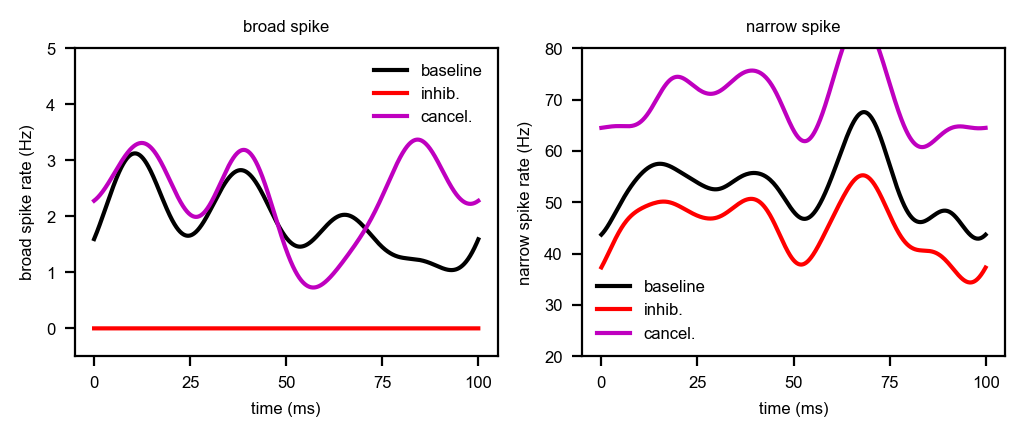

In [32]:
plot_summary_3_cond(data_baseline_noise_soma,data_soma_inh_noise_soma,data_soma_can_noise_soma,ylim_nspk = [20,80])    

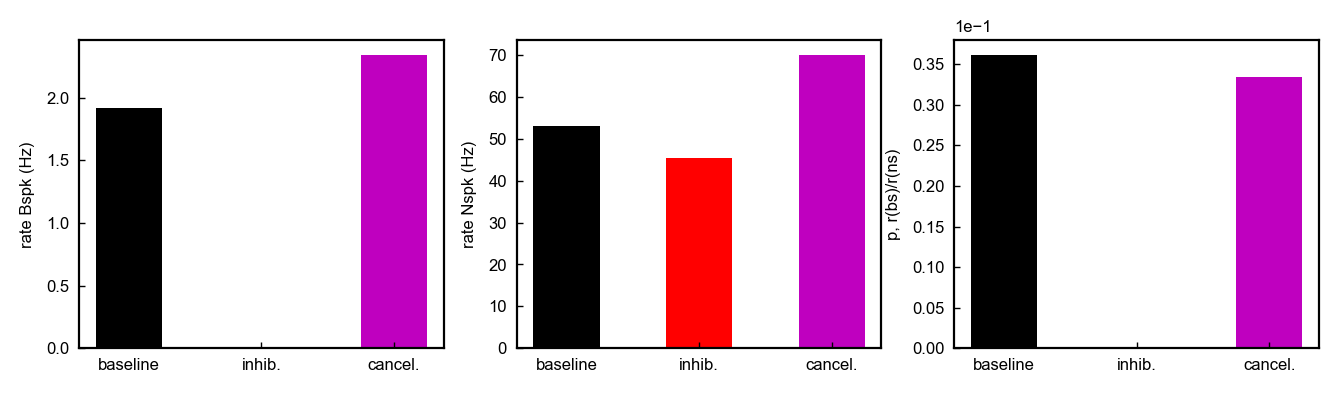

In [33]:
plot_summary_3_cond_bg(data_baseline_noise_soma,data_soma_inh_noise_soma,data_soma_can_noise_soma)    

# apical inhibition

In [34]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

apical_inh = True
Inh_gmax = 0.01 #0.06
pf_exc_canc_inh = False
canc_gmax = 0 #.000083
Nspk_up_Bspk_down = False
after_minus_before = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Inh = True
    Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh_gmax = Inh_gmax, apical_inh = apical_inh,\
                          pf_exc_canc_inh = pf_exc_canc_inh,canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_apic_inh_noise = all_runs_apic
data_apic_inh_noise_apic_up = all_runs_apic_up
data_apic_inh_noise_soma = all_runs
data_apic_inh_noise_axon = all_runs_axon
data_apic_inh_ina = all_runs_ina 
data_apic_inh_ik = all_runs_ik 
data_apic_inh_m = all_runs_m 
data_apic_inh_h = all_runs_h 
data_apic_inh_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_apic_inh = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_apic_inh = spk_times_all['peaks_bspk_all']
nspk_peak_apic_inh = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]


56.25736093521118


14
46
16
9


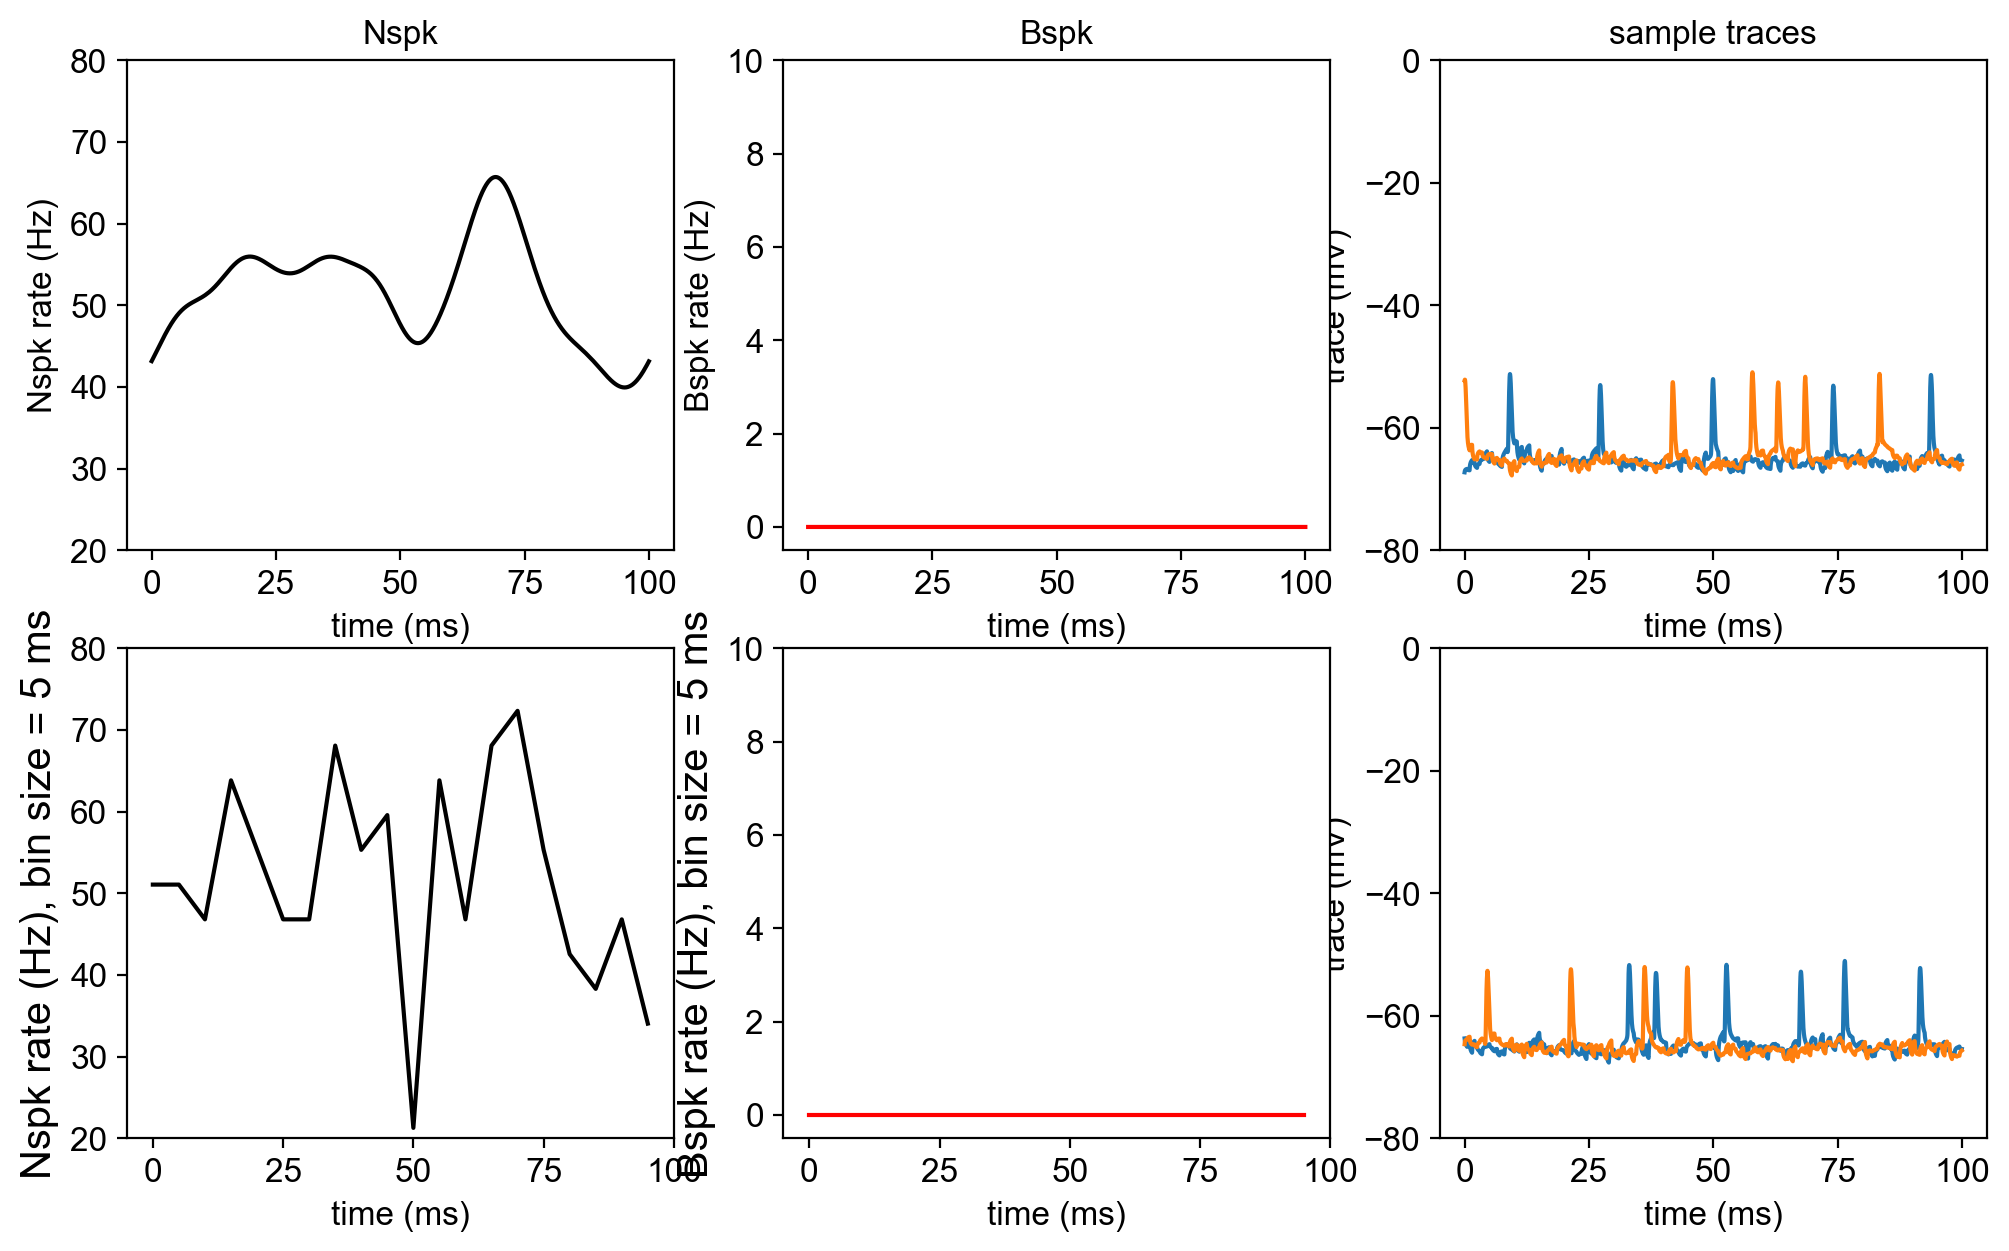

In [35]:
plot_spikes(data_apic_inh_noise_soma, ylim_nspk = [20,80])

In [36]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

apical_inh = True
Inh_gmax = 0.01 #0.08
pf_exc_canc_inh = True
canc_gmax = 7.1e-5 #.00004
Nspk_up_Bspk_down = False
after_minus_before = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, apical_inh = apical_inh, Inh_gmax = Inh_gmax,\
                          pf_exc_canc_inh = pf_exc_canc_inh,canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_apic_can_noise = all_runs_apic
data_apic_can_noise_apic_up = all_runs_apic_up
data_apic_can_noise_soma = all_runs
data_apic_can_noise_axon = all_runs_axon
data_apic_can_ina = all_runs_ina 
data_apic_can_ik = all_runs_ik 
data_apic_can_m = all_runs_m 
data_apic_can_h = all_runs_h 
data_apic_can_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_apic_can = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_apic_can = spk_times_all['peaks_bspk_all']
nspk_peak_apic_can = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]


163.6139280796051


26
30
43
17


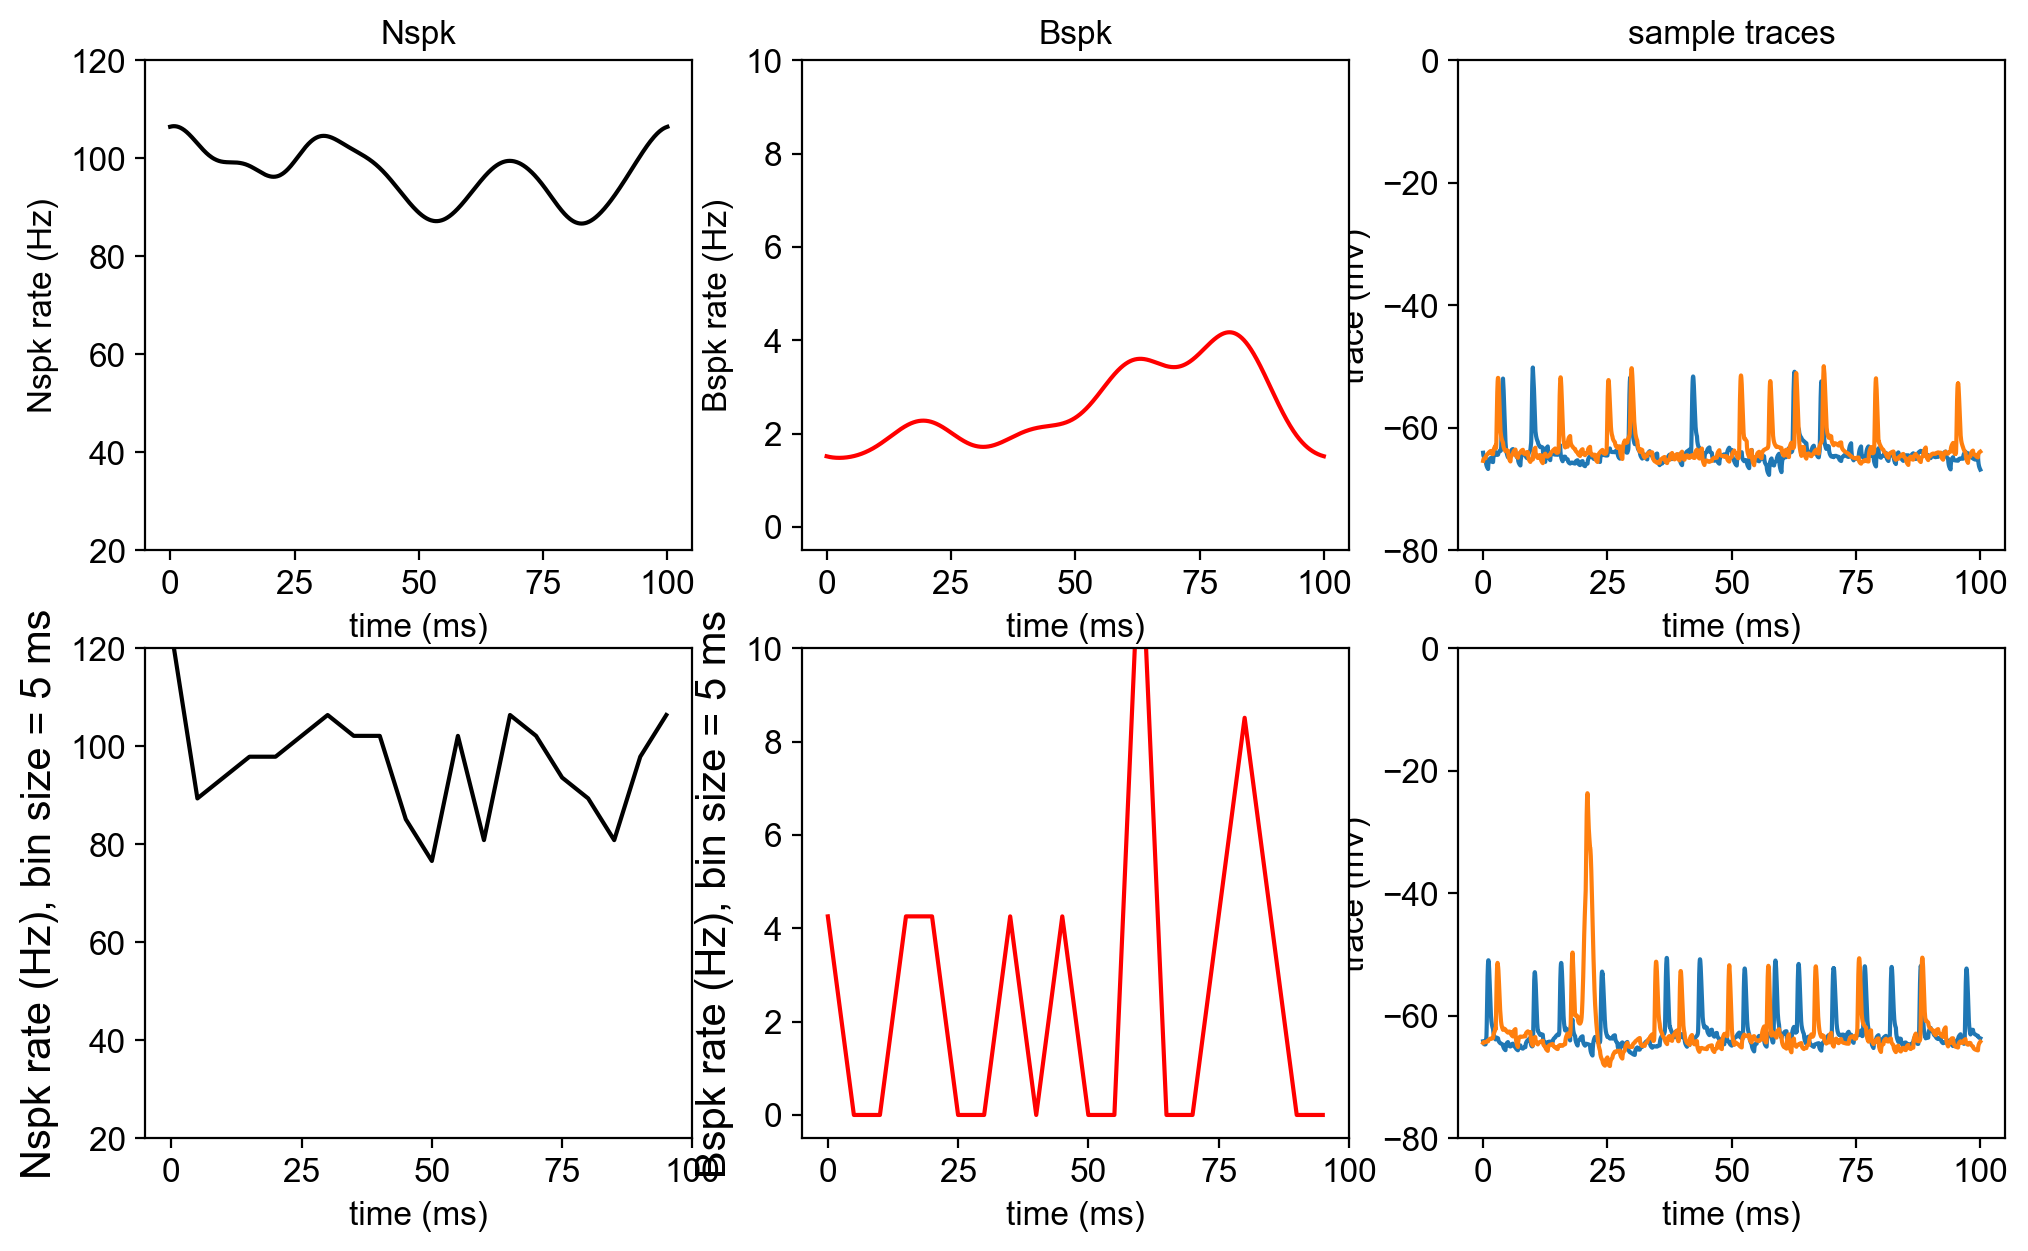

In [37]:
plot_spikes(data_apic_can_noise_soma, ylim_nspk = [20,120])

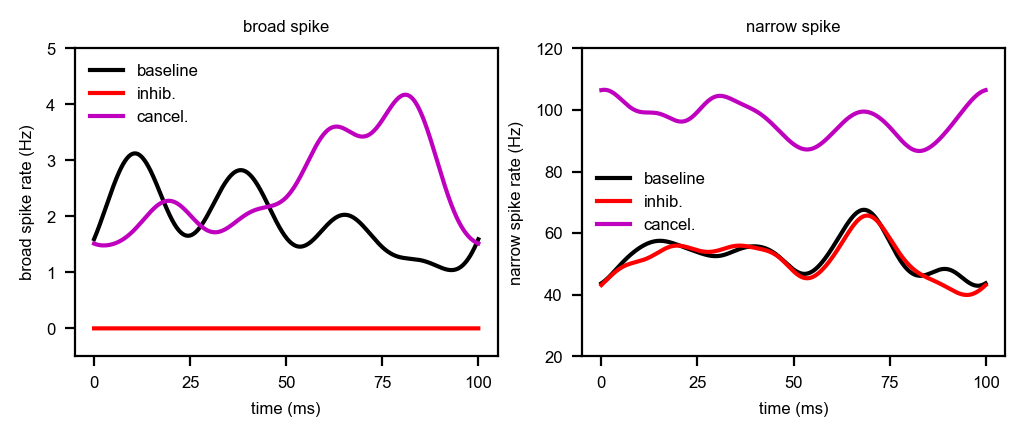

In [38]:
plot_summary_3_cond(data_baseline_noise_soma,data_apic_inh_noise_soma,data_apic_can_noise_soma,ylim_nspk = [20,120])    


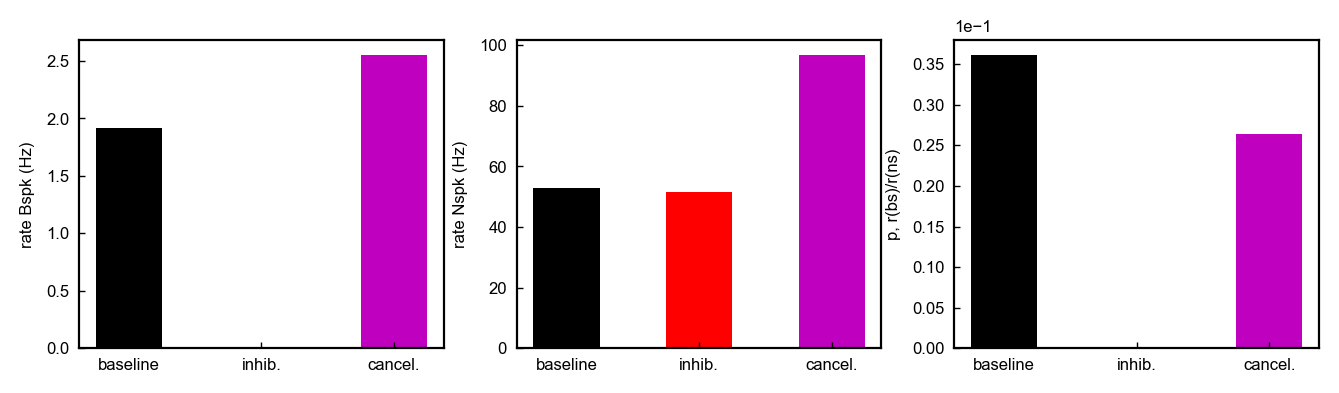

In [39]:
plot_summary_3_cond_bg(data_baseline_noise_soma,data_apic_inh_noise_soma,data_apic_can_noise_soma)    


# Opposite

In [40]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

Inh = False
Inh_gmax = 0 #0.03 
pf_exc_canc_inh = False
canc_gmax = 0 #.000083
Nspk_up_Bspk_down = True
after_minus_before = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Inh = True
    Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh_gmax = Inh_gmax, pf_exc_canc_inh = pf_exc_canc_inh,\
                          canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_opposite_noise = all_runs_apic
data_opposite_noise_apic_up = all_runs_apic_up
data_opposite_noise_soma = all_runs
data_opposite_noise_axon = all_runs_axon
data_opposite_ina = all_runs_ina 
data_opposite_ik = all_runs_ik 
data_opposite_m = all_runs_m 
data_opposite_h = all_runs_h 
data_opposite_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_opposite = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_opposite = spk_times_all['peaks_bspk_all']
nspk_peak_opposite = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]


123.30225825309753


10
19
16
25


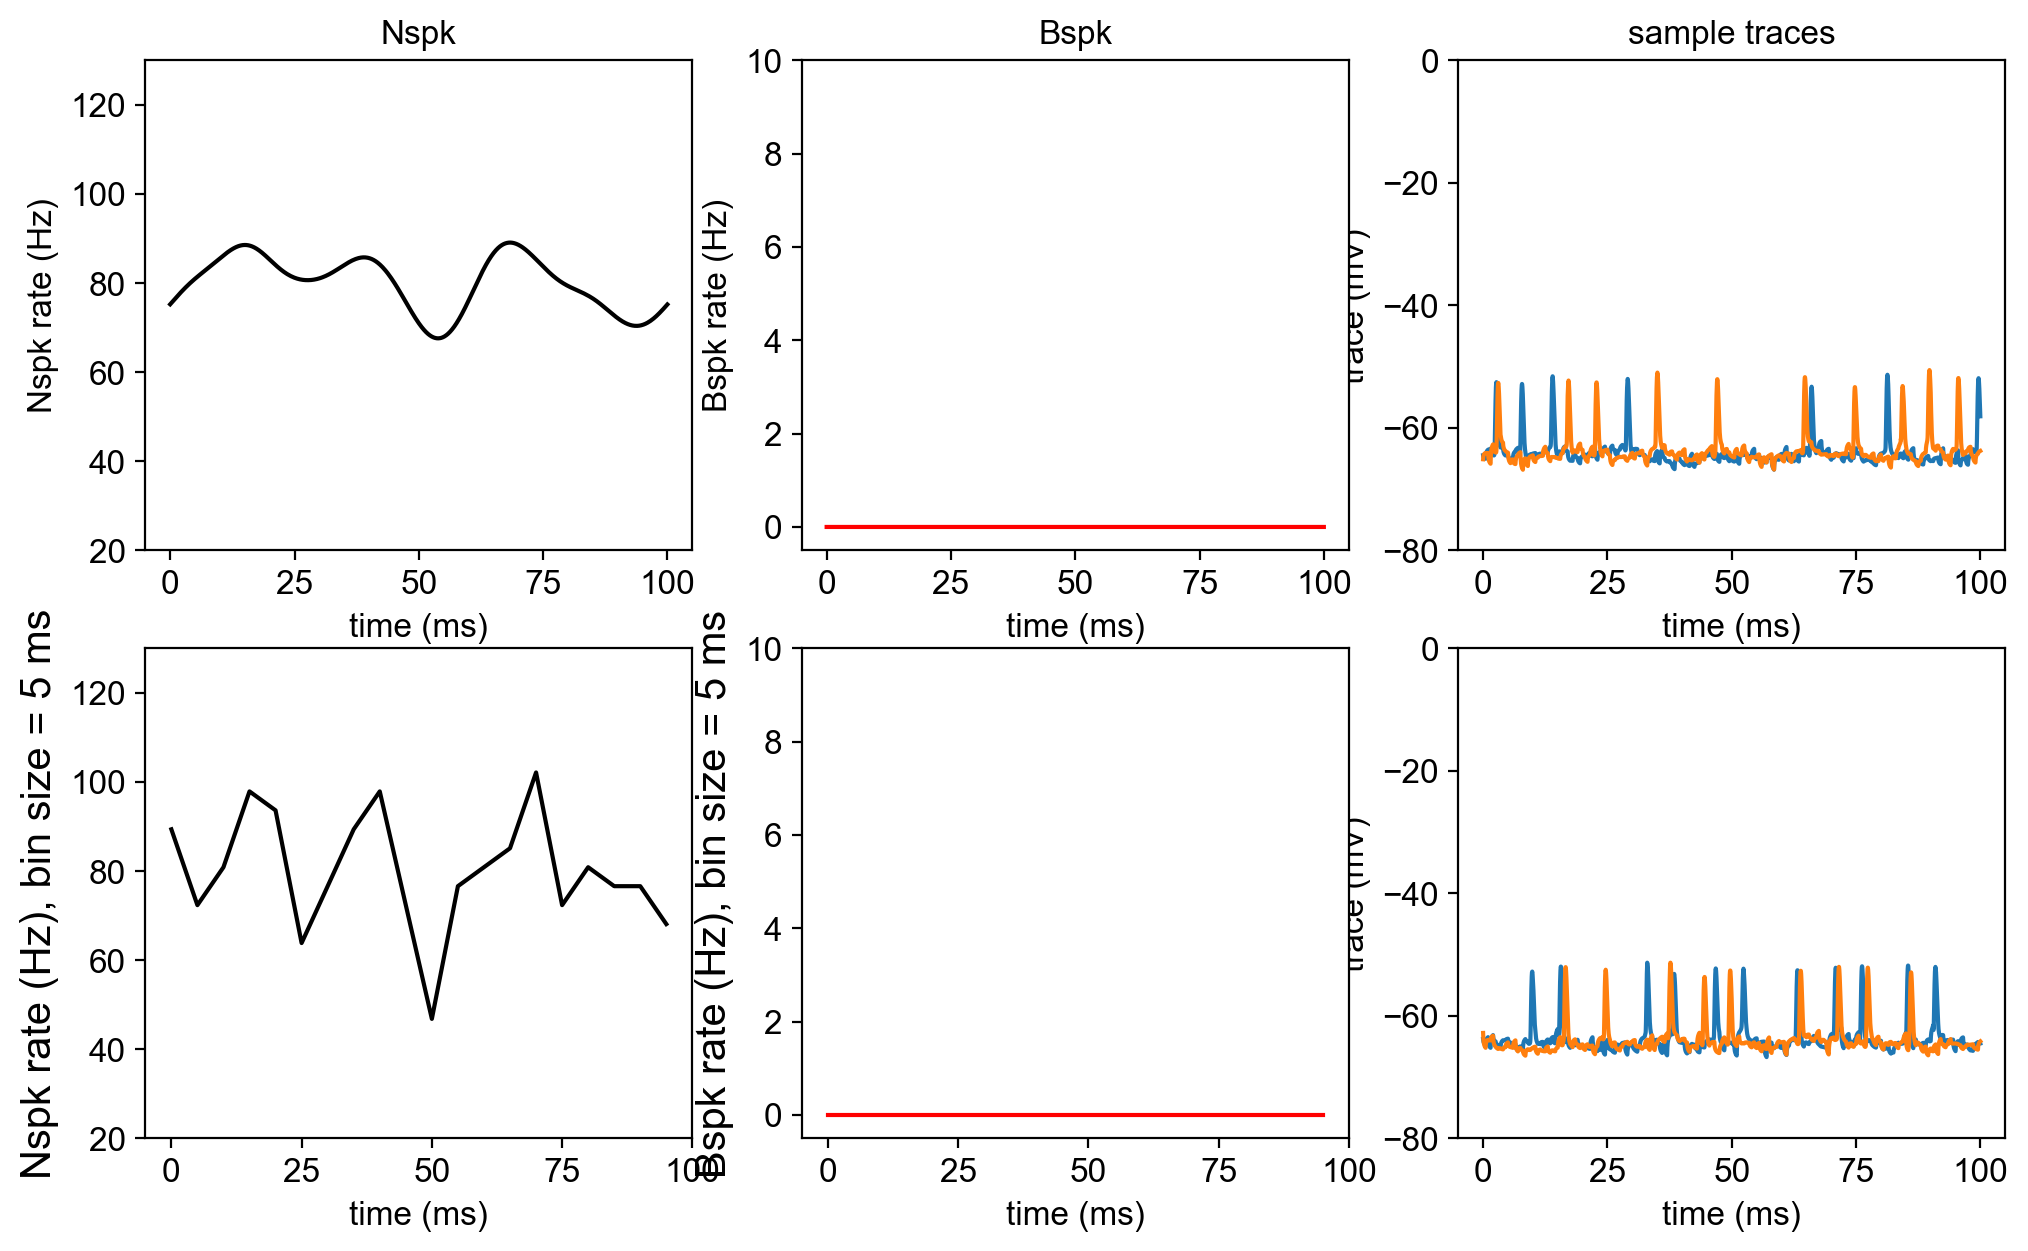

In [41]:
plot_spikes(data_opposite_noise_soma, ylim_nspk = [20,130])


In [42]:
t = time.time()
np.random.seed(seed=1)
nr_runs = 10
stim_dur = 5000
trial_length = 100
eliminate_trials = 3
record_conduc = True
continuous_sensory = True

Inh = False
Inh_gmax = 0 #0.03 
pf_exc_canc_inh = False
can_opposite = True
canc_gmax = 7.8e-5 #.000083
Nspk_up_Bspk_down = True
after_minus_before = False

# if Nspk_up_Bspk_down:
#     Inh = False
#     pf_exc_canc_inh = False
    
# if pf_exc_canc_inh:
#     Inh = True
#     Nspk_up_Bspk_down = False

if after_minus_before:
    Inh = False
    pf_exc_canc_inh = True
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
all_runs_apic_up = []
all_runs_axon = []

all_runs_ina = []
all_runs_ik = []
all_runs_m = []
all_runs_h = []
all_runs_n = []

for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh_gmax = Inh_gmax, pf_exc_canc_inh = pf_exc_canc_inh,\
                          can_opposite = can_opposite, canc_gmax = canc_gmax, Nspk_up_Bspk_down = Nspk_up_Bspk_down,\
                          stim_dur = stim_dur, continuous_sensory = continuous_sensory, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic_up,trial_length_dt = trace_to_trials(results_all['v_vec_apic_up'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_axon,trial_length_dt = trace_to_trials(results_all['v_vec_axon'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic
    all_runs_apic_up = all_runs_apic_up+all_trials_apic_up
    all_runs_axon = all_runs_axon+all_trials_axon

    if record_conduc:
        all_trials_ina,trial_length_dt = trace_to_trials(results_all['ina_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
        all_trials_ik,trial_length_dt = trace_to_trials(results_all['ik_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_m,trial_length_dt = trace_to_trials(results_all['m_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_h,trial_length_dt = trace_to_trials(results_all['h_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
        all_trials_n,trial_length_dt = trace_to_trials(results_all['n_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                     trial_length = trial_length)
    
    
        all_runs_ina = all_runs_ina+all_trials_ina
        all_runs_ik = all_runs_ik+all_trials_ik
        all_runs_m = all_runs_m+all_trials_m
        all_runs_h = all_runs_h+all_trials_h
        all_runs_n= all_runs_n+all_trials_n
    
all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

data_can_oppos_noise = all_runs_apic
data_can_oppos_noise_apic_up = all_runs_apic_up
data_can_oppos_noise_soma = all_runs
data_can_oppos_noise_axon = all_runs_axon
data_can_oppos_ina = all_runs_ina 
data_can_oppos_ik = all_runs_ik 
data_can_oppos_m = all_runs_m 
data_can_oppos_h = all_runs_h 
data_can_oppos_n = all_runs_n

spk_times_all = turn_trace_to_spk([np.hstack(all_runs)], min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

peaks_nspk_loc_can_oppos = spk_times_all['peaks_nspk_all']
peaks_bspk_loc_can_oppos = spk_times_all['peaks_bspk_all']
nspk_peak_can_oppos = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]


224.11512088775635


43
9
42
37


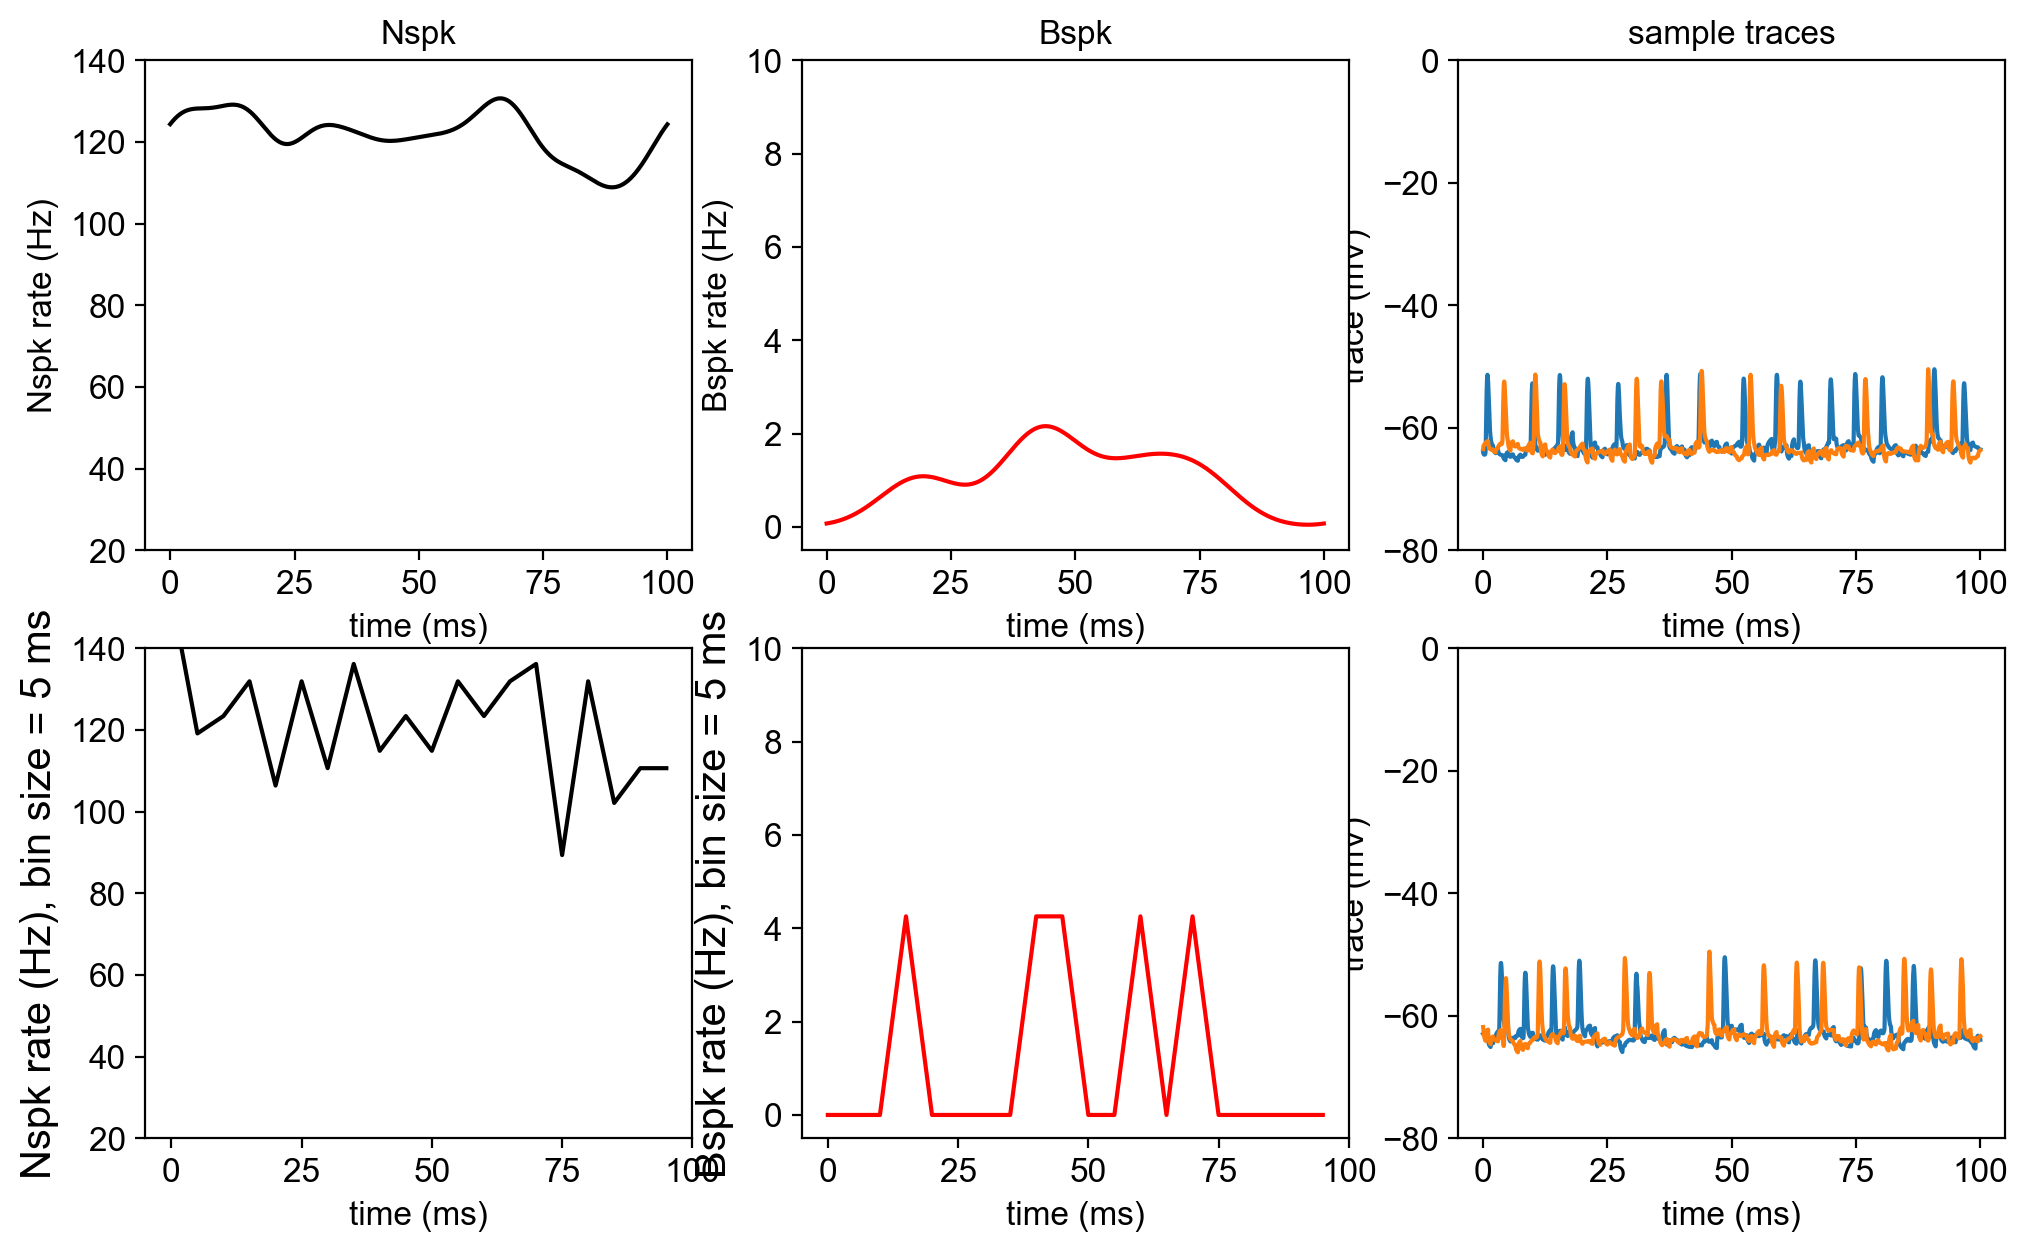

In [43]:
plot_spikes(data_can_oppos_noise_soma, ylim_nspk = [20,140])

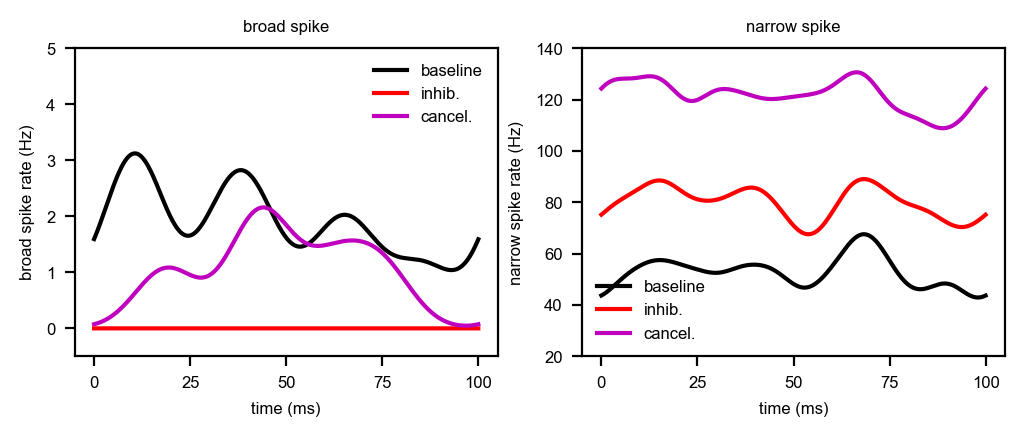

In [44]:
plot_summary_3_cond(data_baseline_noise_soma,data_opposite_noise_soma,data_can_oppos_noise_soma,ylim_nspk = [20,140])    


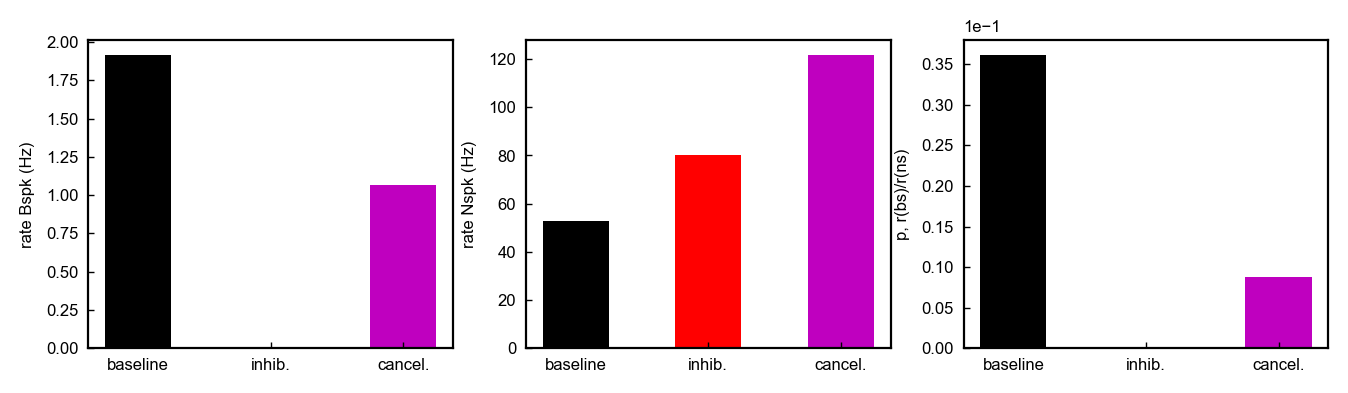

In [45]:
plot_summary_3_cond_bg(data_baseline_noise_soma,data_opposite_noise_soma,data_can_oppos_noise_soma)    

# summary figure

In [46]:
%matplotlib osx
nr_cases = 4
nr_nspk = np.zeros([nr_cases,3])
nr_bspk = np.zeros([nr_cases,3])
ratio_all = np.zeros([nr_cases,3])

dt = 0.025
loc_up_apic = 0.12/dt
loc_up_apic_up = 0.25/dt

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

colr = ['k','r','m']
titles = ['bl', 'inh','can']
title_top = ['apical', 'basal','somatic','opposite']

fig = plt.figure(figsize=(2*8,2*4))

for jj in range(np.size(nr_nspk,0)):
    for kk in range(np.size(nr_nspk,1)):

        if jj == 0 and kk == 0:
            data_soma = [np.hstack(data_baseline_noise_soma)]
        elif jj == 0 and kk == 1:    
            data_soma = [np.hstack(data_apic_inh_noise_soma)]        
        elif jj == 0 and kk == 2:    
            data_soma = [np.hstack(data_apic_can_noise_soma)]
        elif jj == 1 and kk == 0: 
            continue
        elif jj == 1 and kk == 1:    
            data_soma = [np.hstack(data_inhibition_noise_soma)]        
        elif jj == 1 and kk == 2:    
            data_soma = [np.hstack(data_cancellation_noise_soma)]
        elif jj == 2 and kk == 0: 
            continue
        elif jj == 2 and kk == 1:    
            data_soma = [np.hstack(data_soma_inh_noise_soma)]        
        elif jj== 2 and kk == 2:    
            data_soma = [np.hstack(data_soma_can_noise_soma)]
        elif jj == 3 and kk == 0: 
            continue
        elif jj == 3 and kk == 1:    
            data_soma = [np.hstack(data_opposite_noise_soma)]        
        elif jj == 3 and kk == 2:    
            data_soma = [np.hstack(data_can_oppos_noise_soma)]
            
        spk_times_all = turn_trace_to_spk(data_soma, min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                          prom_nspk = 3, prom_bspk = 15)

        peaks_nspk_loc = spk_times_all['peaks_nspk_all']
        peaks_bspk_loc = spk_times_all['peaks_bspk_all']
        if jj == 0 and kk == 0:
            nr_nspk[:,kk] = len(np.concatenate(peaks_nspk_loc))/(len(data_soma[0])/(1/(dt*0.001)))
            nr_bspk[:,kk] = len(np.concatenate(peaks_bspk_loc))/(len(data_soma[0])/(1/(dt*0.001)))
            ratio_all[:,kk] = nr_bspk[:,kk]/nr_nspk[:,kk]
        else:         
            nr_nspk[jj,kk] = len(np.concatenate(peaks_nspk_loc))/(len(data_soma[0])/(1/(dt*0.001)))
            nr_bspk[jj,kk] = len(np.concatenate(peaks_bspk_loc))/(len(data_soma[0])/(1/(dt*0.001)))
            ratio_all[jj,kk] = nr_bspk[jj,kk]/nr_nspk[jj,kk]
    if jj == 3:
        colr = ['k','g','m']

        
    plt.subplot(4,3,3*jj+1)
    plt.bar(titles[0:3],nr_bspk[jj,:],color=colr,width = 0.5)
    plt.ylabel('broad spike rate (Hz)', fontsize = fs)
    ax = plt.gca()
    ax.fontsize = fs
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    plt.subplot(4,3,3*jj+2)
    plt.bar(titles[0:3],nr_nspk[jj,:],color=colr,align='center',width = 0.5)
    plt.ylabel('narrow spike rate (Hz)', fontsize = fs)
    plt.title(title_top[jj], fontsize = fs) 
    ax = plt.gca()
    ax.fontsize = fs
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.subplot(4,3,3*jj+3)
    plt.bar(titles[0:3],ratio_all[jj,:],color=colr,width = 0.5)
    plt.ylabel('p, r(bs)/r(ns)', fontsize = fs)
    ax = plt.gca()
    ax.fontsize = fs
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
    grid_color='k', grid_alpha=1)
    ax.ticklabel_format(axis='y', style='', scilimits=(-1,-1), useOffset=None, useLocale=None, useMathText=None)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# traces

In [48]:
%matplotlib osx

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

fig = plt.figure(figsize=(2,2))

data_bl = np.hstack(data_baseline_noise_soma)
data_inh = np.hstack(data_inhibition_noise_soma)
data_canc = np.hstack(data_cancellation_noise_soma)

# x_lim = [25600,26500] [97400,97750]
x_lim = [54250,54560]
tt = np.linspace(0,(x_lim[1]-x_lim[0])*0.025,x_lim[1]-x_lim[0])
plt.plot(tt,data_bl[x_lim[0]:x_lim[1]],'k')
plt.plot(tt,data_inh[x_lim[0]:x_lim[1]],'r')
plt.plot(tt,data_canc[x_lim[0]:x_lim[1]],'m')

plt.ylabel('mV',fontsize = 7)
plt.xlabel('time (ms)',fontsize = 7)
ax = plt.gca()
y_lim = ax.get_ylim()
x_lim = ax.get_xlim()
ax.autoscale(enable=True, axis='x', tight=True)
plt.plot(x_lim,[-50.3,-50.3],'k',linestyle = '--',linewidth = 1)

ax.set_ylim(y_lim[0], -48)
ax.fontsize = fs
ax.FontName = 'Arial'
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
grid_color='k', grid_alpha=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


# Amplitude analysis

In [49]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


In [50]:
dt = 0.025
time_before_pk = int(np.round(0.7/dt))
min_der = 0.08
add_ind = 1
min_ind = 2

In [51]:
# %matplotlib osx

fig = plt.figure(figsize=(6,8))

fs = 12
ts = 12
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

nr_hist = 200
x_range = [-65,-52]
y_range = [0,0.15]


titles = ['baseline','inhib.','cancel.','opposite','oppos_can']
sites = ['soma','apic','apic up']

dt = 0.025
loc_up_apic = 0.12/dt
loc_up_apic_up = 0.25/dt
base_nspk = int(np.round(0.675/dt))


time_before_pk = int(np.round(0.7/dt))
min_der = 0.08

peak_fit_all = {}
lnspc_peak_fit_all = {}
height_fit_all = {}
lnspc_height_fit_all = {}
mp_fit_all = {}
lnspc_mp_fit_all = {}

use_basil_inh = True
use_soma_inh = False
use_apic_inh = False
use_oppos = False

show_apic = False

for kk in range(3):
    
    if kk == 0:
        data_apic_up = [np.hstack(data_baseline_noise_apic_up)]
        data_soma = [np.hstack(data_baseline_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_baseline
        peaks_bspk_loc = peaks_bspk_loc_baseline
        nspk_peak = nspk_peak_baseline
    if kk>0:
        if use_basil_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_inhibition_noise_apic_up)]
                data_soma = [np.hstack(data_inhibition_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_inhibition
                peaks_bspk_loc = peaks_bspk_loc_inhibition
                nspk_peak = nspk_peak_inhibition
            elif kk == 2: 
                data_apic_up = [np.hstack(data_cancellation_noise_apic_up)]
                data_soma = [np.hstack(data_cancellation_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_cancellation
                peaks_bspk_loc = peaks_bspk_loc_cancellation
                nspk_peak = nspk_peak_cancellation
        elif use_apic_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_apic_inh_noise_apic_up)]
                data_soma = [np.hstack(data_apic_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_apic_inh
                peaks_bspk_loc = peaks_bspk_loc_apic_inh
                nspk_peak = nspk_peak_apic_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_apic_can_noise_apic_up)]
                data_soma = [np.hstack(data_apic_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_apic_can
                peaks_bspk_loc = peaks_bspk_loc_apic_can
                nspk_peak = nspk_peak_apic_can
        elif use_soma_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_soma_inh_noise_apic_up)]
                data_soma = [np.hstack(data_soma_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_soma_inh
                peaks_bspk_loc = peaks_bspk_loc_soma_inh
                nspk_peak = nspk_peak_soma_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_soma_can_noise_apic_up)]
                data_soma = [np.hstack(data_soma_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_soma_can
                peaks_bspk_loc = peaks_bspk_loc_soma_can
                nspk_peak = nspk_peak_soma_can
        elif use_oppos:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_opposite_noise_apic_up)]
                data_soma = [np.hstack(data_opposite_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_opposite
                peaks_bspk_loc = peaks_bspk_loc_opposite
                nspk_peak = nspk_peak_opposite
            elif kk == 2: 
                data_apic_up = [np.hstack(data_can_oppos_noise_apic_up)]
                data_soma = [np.hstack(data_can_oppos_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_can_oppos
                peaks_bspk_loc = peaks_bspk_loc_can_oppos
                nspk_peak = nspk_peak_can_oppos

        
    if show_apic:
        if kk == 0 or kk == 1:
            min_pk_nsp = -60
        elif kk == 2:
            min_pk_nsp = -58.5
                
        spk_times_all = turn_trace_to_spk(data_apic_up, min_hight_nspk = min_pk_nsp, min_hight_bspk = -47.5,\
                                          prom_nspk = 1.5, prom_bspk = 15)
        peaks_nspk_loc_apic_up = np.concatenate(spk_times_all['peaks_nspk_all'])
        peaks_bspk_loc_apic_up = np.concatenate(spk_times_all['peaks_bspk_all'])
        nspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_nspk_all']])
        bspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_bspk_all']])
        
        data_rel = np.concatenate(data_apic_up)
        pks_rel = nspk_peaks_all_apic_up
        peaks_loc_rel = peaks_nspk_loc_apic_up
        
    else:
        data_rel = np.concatenate(data_soma)
        pks_rel = np.concatenate(nspk_peak) 
        peaks_loc_rel = np.concatenate(peaks_nspk_loc)
        
        

    fst_dev = np.diff(data_rel,1)
    fst_dev = np.insert(fst_dev,0, 0)

    mp_nspk_loc = np.array([peaks_loc_rel[ii]-time_before_pk+add_ind+np.where(fst_dev[peaks_loc_rel[ii]-time_before_pk:peaks_loc_rel[ii]]>min_der)[0][0] for ii in range(len(peaks_loc_rel))],dtype=int)
    MP = data_rel[mp_nspk_loc]
    AMP = pks_rel-MP    
    
    print(np.mean(AMP)) 
    print(np.mean(MP))    
    
    if show_apic:
        x_range_peak = [-60,-50]
    else:
        x_range_peak = [-56,-48]

    
    plt.subplot(3,3,1+kk*3)
    plt.hist(pks_rel,nr_hist,density=True, color = 'k')
    plt.title(titles[kk], fontsize = ts)
    plt.ylabel('density', fontsize = fs)
    plt.xlim(x_range_peak)
    bottom, top = plt.ylim()
    plt.vlines(np.median(pks_rel), bottom, top, colors='r', linestyles='dashed', label='');
    if kk == 2:
        plt.xlabel('peak (mV)', fontsize = fs)

    xt = plt.xticks()[0]  
    xmin, xmax = min(xt), max(xt)  
    lnspc = np.linspace(xmin, xmax, len(pks_rel))    
        
    pdf_plot = kde_scipy(pks_rel, lnspc, bandwidth=0.2)

    plt.plot(lnspc, pdf_plot,'r',linewidth=2)
    lnspc_peak_fit_all[titles[kk]] = lnspc
    peak_fit_all[titles[kk]] = pdf_plot

    
    if show_apic:
        x_range_height = [5,11]
    else:
        x_range_height = [8.5,16.5] 
        
    
    plt.subplot(3,3,2+kk*3)
    plt.hist(AMP ,nr_hist,density=True, color = 'k')
    plt.title(titles[kk], fontsize = ts)
    plt.ylabel('density', fontsize = fs)
    plt.xlim(x_range_height)
    bottom, top = plt.ylim()
    plt.vlines(np.median(AMP), bottom, top, colors='r', linestyles='dashed', label='');
    if kk == 2:
        plt.xlabel('AMP (mV)', fontsize = fs)
        
    xt = plt.xticks()[0]  
    xmin, xmax = max(min(xt),0.1), max(xt)  
    lnspc = np.linspace(xmin, xmax, len(AMP))    

    pdf_plot = kde_scipy(AMP, lnspc, bandwidth=0.2)
    plt.plot(lnspc, pdf_plot, color='r',lw=2)
    lnspc_height_fit_all[titles[kk]] = lnspc
    height_fit_all[titles[kk]] = pdf_plot

    
    if show_apic:
        x_range_mp = [-67, -61.5]
    else:
        x_range_mp = [-68, -60]
        
    
    plt.subplot(3,3,3+kk*3)
    plt.hist(MP ,nr_hist,density=True, color = 'k')
    plt.title(titles[kk], fontsize = ts)
    plt.ylabel('density', fontsize = fs)
    plt.xlim(x_range_mp)
    bottom, top = plt.ylim()
    plt.vlines(np.median(MP), bottom, top, colors='r', linestyles='dashed', label='');
    if kk == 2:
        plt.xlabel('MP (mV)', fontsize = fs)
        
    xt = plt.xticks()[0]  
    xmin, xmax = min(xt), max(xt)  
    lnspc = np.linspace(xmin, xmax, len(MP))    

    pdf_plot = kde_scipy(MP, lnspc, bandwidth=0.2)
    plt.plot(lnspc, pdf_plot, color='r',lw=2)
    lnspc_mp_fit_all[titles[kk]] = lnspc
    mp_fit_all[titles[kk]] = pdf_plot

plt.show()



12.316902131118827
-63.93844780579233
11.528043303236707
-64.03377168066446
11.444960079950812
-63.22092221666569


In [52]:

fig = plt.figure(figsize=(6,2))
fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

titles_leg = ['baseline','inhibition','cancellation']
titles = ['baseline','inhib.','cancel.','opposite','oppos_can']
colr = ['k','r','m','g','y']

rng_nm = 3

plt.subplot(1,3,1)
for kk in range(rng_nm):
    plt.plot(lnspc_peak_fit_all[titles[kk]], peak_fit_all[titles[kk]],color = colr[kk])
    if kk ==2:
        plt.legend(titles[0:kk+1],frameon = False)
        plt.xlabel('Peak (mV)', fontsize = fs)
        plt.ylabel('density', fontsize = fs)
    plt.xlim(x_range_peak)
ax = plt.gca()
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
               grid_color='k', grid_alpha=1)

plt.subplot(1,3,2)
for kk in range(rng_nm):
    plt.plot(lnspc_height_fit_all[titles[kk]], height_fit_all[titles[kk]],color = colr[kk])
    if kk ==2:
        plt.xlabel('AMP (mV)', fontsize = fs)
        plt.ylabel('density', fontsize = fs)
    plt.xlim(x_range_height)

ax = plt.gca()
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
               grid_color='k', grid_alpha=1)

 
plt.subplot(1,3,3)
for kk in range(rng_nm):
    plt.plot(lnspc_mp_fit_all[titles[kk]], mp_fit_all[titles[kk]],color = colr[kk])
    if kk ==2:
        plt.xlabel('MP (mV)', fontsize = fs)
        plt.ylabel('density', fontsize = fs)
    plt.xlim(x_range_mp)

ax = plt.gca()
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
               grid_color='k', grid_alpha=1)

plt.show()    
    

# Bar graphs

In [53]:
# %matplotlib osx

fig = plt.figure(figsize=(9,2))

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

std_peak = np.zeros((1,3))

titles = ['baseline','inhib.','cancel.','opposite','oppos_can']
sites = ['soma','apic','apic up']

dt = 0.025

use_basil_inh = True
use_soma_inh = False
use_apic_inh = False
use_oppos = False

show_apic = True

clr = ['k','r','m']

for kk in range(3):
    
    if kk == 0:
        data_apic_up = [np.hstack(data_baseline_noise_apic_up)]
        data_soma = [np.hstack(data_baseline_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_baseline
        peaks_bspk_loc = peaks_bspk_loc_baseline
        nspk_peak = nspk_peak_baseline
    if kk>0:
        if use_basil_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_inhibition_noise_apic_up)]
                data_soma = [np.hstack(data_inhibition_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_inhibition
                peaks_bspk_loc = peaks_bspk_loc_inhibition
                nspk_peak = nspk_peak_inhibition
            elif kk == 2: 
                data_apic_up = [np.hstack(data_cancellation_noise_apic_up)]
                data_soma = [np.hstack(data_cancellation_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_cancellation
                peaks_bspk_loc = peaks_bspk_loc_cancellation
                nspk_peak = nspk_peak_cancellation
        elif use_apic_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_apic_inh_noise_apic_up)]
                data_soma = [np.hstack(data_apic_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_apic_inh
                peaks_bspk_loc = peaks_bspk_loc_apic_inh
                nspk_peak = nspk_peak_apic_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_apic_can_noise_apic_up)]
                data_soma = [np.hstack(data_apic_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_apic_can
                peaks_bspk_loc = peaks_bspk_loc_apic_can
                nspk_peak = nspk_peak_apic_can
        elif use_soma_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_soma_inh_noise_apic_up)]
                data_soma = [np.hstack(data_soma_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_soma_inh
                peaks_bspk_loc = peaks_bspk_loc_soma_inh
                nspk_peak = nspk_peak_soma_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_soma_can_noise_apic_up)]
                data_soma = [np.hstack(data_soma_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_soma_can
                peaks_bspk_loc = peaks_bspk_loc_soma_can
                nspk_peak = nspk_peak_soma_can
        elif use_oppos:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_opposite_noise_apic_up)]
                data_soma = [np.hstack(data_opposite_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_opposite
                peaks_bspk_loc = peaks_bspk_loc_opposite
                nspk_peak = nspk_peak_opposite
            elif kk == 2: 
                data_apic_up = [np.hstack(data_can_oppos_noise_apic_up)]
                data_soma = [np.hstack(data_can_oppos_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_can_oppos
                peaks_bspk_loc = peaks_bspk_loc_can_oppos
                nspk_peak = nspk_peak_can_oppos

        
    if show_apic:
        if kk == 0 or kk == 1:
            min_pk_nsp = -60
        elif kk == 2:
            min_pk_nsp = -58.5
                
        spk_times_all = turn_trace_to_spk(data_apic_up, min_hight_nspk = min_pk_nsp, min_hight_bspk = -47.5,\
                                          prom_nspk = 1.5, prom_bspk = 15)
        peaks_nspk_loc_apic_up = np.concatenate(spk_times_all['peaks_nspk_all'])
        peaks_bspk_loc_apic_up = np.concatenate(spk_times_all['peaks_bspk_all'])
        nspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_nspk_all']])
        bspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_bspk_all']])
        
        data_rel = np.concatenate(data_apic_up)
        PEAK = nspk_peaks_all_apic_up
        peaks_loc_rel = peaks_nspk_loc_apic_up
        
    else:
        data_rel = np.concatenate(data_soma)
        PEAK = np.concatenate(nspk_peak) 
        peaks_loc_rel = np.concatenate(peaks_nspk_loc)

    snd_dev = np.diff(data_rel,1)
    snd_dev = np.insert(snd_dev,0, 0)

    mp_nspk_loc = np.array([peaks_loc_rel[ii]-time_before_pk+add_ind+np.where(snd_dev[peaks_loc_rel[ii]-time_before_pk:peaks_loc_rel[ii]]>min_der)[0][0] for ii in range(len(peaks_loc_rel))],dtype=int)
    MP = data_rel[mp_nspk_loc]
    AMP = PEAK-MP    
    
    print(np.mean(PEAK))    
    print(np.mean(AMP)) 
    print(np.mean(MP))

    std_peak[0,kk] = np.std(PEAK)
    
    if show_apic:
        x_range_peak = [-60,-50]
    else:
        x_range_peak = [-56,-48]

    wid = 0.3    
    plt.subplot(1,3,1)
    plt.bar(0.5*kk, np.mean(PEAK), width=wid, color=clr[kk], align='edge')
         
        
    plt.subplot(1,3,2)
    plt.bar(0.5*kk, np.mean(AMP), width=wid, color=clr[kk], align='center')
    
    plt.subplot(1,3,3)
    plt.bar(0.5*kk, np.mean(MP), width=wid, color=clr[kk],align='center')
    plt.subplot(1,3,3)
    
    

plt.subplot(1,3,1)
if show_apic:
    plt.ylim([-58, -55])
else:
    plt.ylim([-53, -49])
ax = plt.gca()
x_lim = ax.get_xlim()
plt.hlines(-50,x_lim[0],x_lim[1],colors='gray')
plt.hlines(-50-np.mean(std_peak),x_lim[0],x_lim[1],colors='green')
plt.ylabel('peak (mV)',fontsize = fs)
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
               grid_color='k', grid_alpha=1)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.axes.xaxis.set_visible(False)


plt.subplot(1,3,2)
if show_apic:
    plt.ylim([6, 8])
else:
    plt.ylim([10, 12.5])
plt.ylabel('ampliptude (mV)',fontsize = fs)
ax = plt.gca()
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
               grid_color='k', grid_alpha=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.axes.xaxis.set_visible(False)



plt.subplot(1,3,3)    
if show_apic:
    plt.ylim([-64.5, -62])
else:
    plt.ylim([-64.5, -62])
plt.ylabel('baseline membrane potential (mV)',fontsize = fs)
ax = plt.gca()
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
               grid_color='k', grid_alpha=1)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.axes.xaxis.set_visible(False)


plt.show()



-56.29533970165176
7.712337431602742
-64.0076771332545
-57.159244191020996
6.915044030602007
-64.07428822162301
-56.07071259006531
7.017876191363046
-63.088588781428356


### AMP vs MP

In [55]:
# %matplotlib osx

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

nr_hist = 200
x_range = [-65,-52]
y_range = [0,0.15]


titles = ['baseline','inhib.','cancel.','opposite','oppos_can']
sites = ['soma','apic','apic up']
colr = ['k','r','m']

dt = 0.025
nspk_before_bspk = np.round(8/dt)
bin_size = 0.1
min_ind = 2

slope_intercept_all = np.zeros((3,2))
mean_AMP_MP_all = np.zeros((3,2))
mean_AMP_evoke_non_all = np.zeros((3,2))

use_basil_inh = True
use_soma_inh = False
use_apic_inh = False

show_apic = False
fig = plt.figure(figsize=(9.5,4.5))

MP_all = np.empty(0)
AMP_all = np.empty(0)
clr_all = np.empty(0)

for kk in range(3):
    
    if kk == 0:
        data_apic_up = [np.hstack(data_baseline_noise_apic_up)]
        data_soma = [np.hstack(data_baseline_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_baseline
        peaks_bspk_loc = peaks_bspk_loc_baseline
        nspk_peak = nspk_peak_baseline
    if kk>0:
        if use_basil_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_inhibition_noise_apic_up)]
                data_soma = [np.hstack(data_inhibition_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_inhibition
                peaks_bspk_loc = peaks_bspk_loc_inhibition
                nspk_peak = nspk_peak_inhibition
            elif kk == 2: 
                data_apic_up = [np.hstack(data_cancellation_noise_apic_up)]
                data_soma = [np.hstack(data_cancellation_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_cancellation
                peaks_bspk_loc = peaks_bspk_loc_cancellation
                nspk_peak = nspk_peak_cancellation
        elif use_apic_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_apic_inh_noise_apic_up)]
                data_soma = [np.hstack(data_apic_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_apic_inh
                peaks_bspk_loc = peaks_bspk_loc_apic_inh
                nspk_peak = nspk_peak_apic_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_apic_can_noise_apic_up)]
                data_soma = [np.hstack(data_apic_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_apic_can
                peaks_bspk_loc = peaks_bspk_loc_apic_can
                nspk_peak = nspk_peak_apic_can
        elif use_soma_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_soma_inh_noise_apic_up)]
                data_soma = [np.hstack(data_soma_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_soma_inh
                peaks_bspk_loc = peaks_bspk_loc_soma_inh
                nspk_peak = nspk_peak_soma_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_soma_can_noise_apic_up)]
                data_soma = [np.hstack(data_soma_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_soma_can
                peaks_bspk_loc = peaks_bspk_loc_soma_can
                nspk_peak = nspk_peak_soma_can

        
        
    if show_apic:
        if kk == 0 or kk == 1:
            min_pk_nsp = -60
        elif kk == 2:
            min_pk_nsp = -58.5
            
        spk_times_all = turn_trace_to_spk(data_apic_up, min_hight_nspk = min_pk_nsp, min_hight_bspk = -47.5,\
                                          prom_nspk = 1.5, prom_bspk = 15)
        peaks_nspk_loc_apic_up = np.concatenate(spk_times_all['peaks_nspk_all'])
        peaks_bspk_loc = (spk_times_all['peaks_bspk_all'])
        nspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_nspk_all']])
        bspk_peaks_all = ([x['peak_heights'] for x in spk_times_all['properties_bspk_all']])
        
        data_rel = np.concatenate(data_apic_up)
        PKS = nspk_peaks_all_apic_up
        peaks_loc_rel = peaks_nspk_loc_apic_up    
    
    else:
        data_rel = np.concatenate(data_soma)
        
        PKS = np.concatenate(nspk_peak) 
        peaks_loc_rel = np.concatenate(peaks_nspk_loc)
        
       

    fst_dev = np.diff(data_rel,1)
    fst_dev = np.insert(fst_dev,0, 0)

    mp_nspk_locs = []
    idx_list = []
    for ii in range(len(peaks_loc_rel)):  
        rel_idx = [peaks_loc_rel[ii]-time_before_pk+add_ind+np.where(fst_dev[peaks_loc_rel[ii]-time_before_pk:peaks_loc_rel[ii]]>min_der)[0]]
        if len(rel_idx[0])>0:
            mp_nspk_locs.append(rel_idx[0][0])
        else:
            print(ii)
            idx_list.append(ii)
         
    PKS = np.delete(PKS,idx_list)  
    peaks_loc_rel = np.delete(peaks_loc_rel,idx_list)  
    
    
    MP = data_rel[mp_nspk_locs]
    AMP = PKS-MP
    
    mean_AMP_MP_all[kk,0] = np.mean(PKS)
    mean_AMP_MP_all[kk,1] = np.mean(MP)

    nbins = np.ceil((np.max(MP)-np.min(MP))/bin_size)
    edges_all = np.linspace(np.min(MP),np.max(MP),num = int(nbins+1))
    counts_all, bins_all = np.histogram(np.array(MP,dtype='float'),bins=edges_all)
    inds_all = np.digitize(np.array(MP,dtype='float'), bins=edges_all)
    mean_amp_all = np.empty((np.size(edges_all)))
    mean_amp_all[:] = np.NaN
    for ii in range(len(edges_all)):
        if np.sum(inds_all == ii) > min_ind:
            mean_amp_all[ii] =  np.mean(AMP[inds_all == ii])                  


    ns_pk_non_evoking = []
    ns_mp_non_evoking = []
    ns_amp_non_evoking = []
    ns_loc_non_evoking = []
    ns_pk_pre = []
    ns_mp_pre = []
    ns_amp_pre = []
    ns_loc_pre_bs = []
    if any(peaks_bspk_loc[0]):
        nspk_before_idx_all = []
        for jj in range(len(peaks_bspk_loc[0])):
            nspk_before_idx = np.concatenate(np.where((peaks_loc_rel > (peaks_bspk_loc[0][jj] - nspk_before_bspk)) & (peaks_loc_rel < peaks_bspk_loc[0][jj])))
            if len(nspk_before_idx) > 0:
                nspk_before_idx = nspk_before_idx[-1]
                nspk_before_idx_all.append(nspk_before_idx)
        idx_all = range(len(PKS))
        nspk_non_before_idx = np.delete(idx_all,nspk_before_idx_all) 
        ns_pk_pre.append(PKS[nspk_before_idx_all])
        ns_loc_pre_bs.append(peaks_loc_rel[nspk_before_idx_all])
        ns_pk_non_evoking.append(PKS[nspk_non_before_idx])    
        ns_loc_non_evoking.append(peaks_loc_rel[nspk_non_before_idx])  

        ns_mp_pre.append(MP[nspk_before_idx_all])
        ns_mp_non_evoking.append(MP[nspk_non_before_idx])    
        ns_amp_pre.append(AMP[nspk_before_idx_all])
        ns_amp_non_evoking.append(AMP[nspk_non_before_idx])
        

        ns_mp_pre_conc = np.concatenate(ns_mp_pre);
        ns_amp_pre_conc = np.concatenate(ns_amp_pre);
        ns_mp_non_evoking_conc = np.concatenate(ns_mp_non_evoking)
        ns_amp_non_evoking_conc = np.concatenate(ns_amp_non_evoking)

        nbins = np.ceil((np.max(MP)-np.min(MP))/bin_size)
        edges = np.linspace(np.min(MP),np.max(MP),num = int(nbins+1))
        inds_non_evoke = np.digitize(np.array(ns_mp_non_evoking_conc ,dtype='float'), bins=edges)
        mean_amp_non_evoke = np.empty((np.size(edges)))
        mean_amp_non_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_non_evoke == ii) > min_ind:
                mean_amp_non_evoke[ii] =  np.mean(ns_amp_non_evoking_conc[inds_non_evoke == ii])                  
        inds_evoke = np.digitize(np.array(ns_mp_pre_conc ,dtype='float'), bins=edges)
        mean_amp_evoke = np.empty((np.size(edges)))
        mean_amp_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_evoke == ii) > min_ind:
                mean_amp_evoke[ii] =  np.mean(ns_amp_pre_conc[inds_evoke == ii])                  
        
        mean_AMP_evoke_non_all[kk,0] = np.mean(ns_amp_pre)
        mean_AMP_evoke_non_all[kk,1] = np.mean(ns_amp_non_evoking)
    else:
        edges = edges_all
        mean_amp_non_evoke = mean_amp_all
        mean_amp_evoke = np.empty((np.size(edges)))
        mean_amp_evoke[:] = np.NaN
        ind_evoke = np.empty((np.size(edges)))
    
    
    
    X_MP  = np.transpose([MP])
    model_cell = LinearRegression(fit_intercept=True).fit(X_MP, np.transpose(AMP))

    if show_apic:
        x_lim = [-67, -61]
        y_lim = [5,11]
    else:
        x_lim = [-67.5,-60]
        y_lim = [7.8,17.2]
        
        
    plt.subplot(2,4,kk+1)
    plt.scatter(MP,AMP,3,color = 'k',facecolors='none')
    plt.ylabel('amplitude (mV)', fontsize = fs)
    plt.xlabel('baseline membrane potential (mV)', fontsize = fs)
    tt = np.arange(np.min(MP), np.max(MP),0.1)
    plt.plot(tt,tt*model_cell.coef_[0]+model_cell.intercept_)
    plt.ylim(y_lim)
    plt.xlim(x_lim)

    plt.title(('%s, slope = %.3f, S/AMP = %.2f %%.'%(titles[kk], model_cell.coef_[0],100*model_cell.coef_[0]/np.mean(AMP))),fontsize = 6.5)
    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)
    
    plt.subplot(2,4,4)  
    plt.scatter(edges_all,mean_amp_all,s=10, color = colr[kk])

    p_quant = 0.1

    tt = np.arange(np.min(MP), np.max(MP),0.1)
    plt.plot(tt,tt*model_cell.coef_[0]+model_cell.intercept_,color = colr[kk])
    
    slope_intercept_all[kk,0] = model_cell.coef_[0]
    slope_intercept_all[kk,1] = model_cell.intercept_
    
    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)
    
    plt.subplot(2,4,4+kk+1)
    plt.scatter(edges,mean_amp_non_evoke,s=10, color='k')
    plt.scatter(edges,mean_amp_evoke,s=15, facecolors='none', edgecolors='k')
    plt.legend(['non-evoking','evoking'],frameon = False)
    plt.tight_layout()
    plt.ylabel('amplitude (mV)', fontsize = fs)
    plt.xlabel('baseline membrane potential (mV)', fontsize = fs)

    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)

plt.subplot(2,4,4)
indc = np.argsort(clr_all)
plt.scatter(MP_all[indc],AMP_all[indc],c=clr_all[indc], s=1,alpha=0.1,facecolors='none')

plt.ylabel('amplitude (mV)', fontsize = fs)
plt.xlabel('baseline membrane potential (mV)', fontsize = fs)
plt.show()



# Peak vs MP

In [56]:
# %matplotlib osx

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

nr_hist = 200
x_range = [-65,-52]
y_range = [0,0.15]


titles = ['baseline','inhib.','cancel.','opposite','oppos_can']
sites = ['soma','apic','apic up']
colr = ['k','r','m']

dt = 0.025
loc_up_apic = 0.12/dt
loc_up_apic_up = 0.25/dt
base_nspk = int(np.round(0.675/dt))


dt = 0.025
nspk_before_bspk = np.round(8/dt)

bin_size = 0.1
min_ind = 0

slope_intercept_all = np.zeros((3,2))
mean_PK_MP_all = np.zeros((3,2))
mean_pks_evoke_non_all = np.zeros((3,2))

use_basil_inh = True
use_soma_inh = False
use_apic_inh = False

show_apic = False
fig = plt.figure(figsize=(9.5,4.5))

for kk in range(3):
    
    if kk == 0:
        data_apic_up = [np.hstack(data_baseline_noise_apic_up)]
        data_soma = [np.hstack(data_baseline_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_baseline
        peaks_bspk_loc = peaks_bspk_loc_baseline
        nspk_peak = nspk_peak_baseline
    if kk>0:
        if use_basil_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_inhibition_noise_apic_up)]
                data_soma = [np.hstack(data_inhibition_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_inhibition
                peaks_bspk_loc = peaks_bspk_loc_inhibition
                nspk_peak = nspk_peak_inhibition
            elif kk == 2: 
                data_apic_up = [np.hstack(data_cancellation_noise_apic_up)]
                data_soma = [np.hstack(data_cancellation_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_cancellation
                peaks_bspk_loc = peaks_bspk_loc_cancellation
                nspk_peak = nspk_peak_cancellation
        elif use_apic_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_apic_inh_noise_apic_up)]
                data_soma = [np.hstack(data_apic_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_apic_inh
                peaks_bspk_loc = peaks_bspk_loc_apic_inh
                nspk_peak = nspk_peak_apic_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_apic_can_noise_apic_up)]
                data_soma = [np.hstack(data_apic_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_apic_can
                peaks_bspk_loc = peaks_bspk_loc_apic_can
                nspk_peak = nspk_peak_apic_can
        elif use_soma_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_soma_inh_noise_apic_up)]
                data_soma = [np.hstack(data_soma_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_soma_inh
                peaks_bspk_loc = peaks_bspk_loc_soma_inh
                nspk_peak = nspk_peak_soma_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_soma_can_noise_apic_up)]
                data_soma = [np.hstack(data_soma_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_soma_can
                peaks_bspk_loc = peaks_bspk_loc_soma_can
                nspk_peak = nspk_peak_soma_can
                    
        
    if show_apic:
        if kk == 0 or kk == 1:
            min_pk_nsp = -60
        elif kk == 2:
            min_pk_nsp = -58.5
            
        spk_times_all = turn_trace_to_spk(data_apic_up, min_hight_nspk = min_pk_nsp, min_hight_bspk = -47.5,\
                                          prom_nspk = 1.5, prom_bspk = 15)
        peaks_nspk_loc_apic_up = np.concatenate(spk_times_all['peaks_nspk_all'])
        peaks_bspk_loc = (spk_times_all['peaks_bspk_all'])
        nspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_nspk_all']])
        bspk_peaks_all = ([x['peak_heights'] for x in spk_times_all['properties_bspk_all']])
        
        data_rel = np.concatenate(data_apic_up)
        PKS = nspk_peaks_all_apic_up
        peaks_loc_rel = peaks_nspk_loc_apic_up    
    
    else:
        data_rel = np.concatenate(data_soma)
        
        PKS = np.concatenate(nspk_peak) 
        peaks_loc_rel = np.concatenate(peaks_nspk_loc)
        
       

    fst_dev = np.diff(data_rel,1)
    fst_dev = np.insert(fst_dev,0, 0)

    mp_nspk_locs = []
    idx_list = []
    for ii in range(len(peaks_loc_rel)):  
        rel_idx = [peaks_loc_rel[ii]-time_before_pk+add_ind+np.where(fst_dev[peaks_loc_rel[ii]-time_before_pk:peaks_loc_rel[ii]]>min_der)[0]]
        if len(rel_idx[0])>0:
            mp_nspk_locs.append(rel_idx[0][0])
        else:
            print(ii)
            idx_list.append(ii)
    PKS = np.delete(PKS,idx_list)  
    peaks_loc_rel = np.delete(peaks_loc_rel,idx_list)  
    
    
    MP = data_rel[mp_nspk_locs]
    AMP = PKS-MP
    
    mean_PK_MP_all[kk,0] = np.mean(PKS)
    mean_PK_MP_all[kk,1] = np.mean(MP)

    ns_pk_non_evoking = []
    ns_mp_non_evoking = []
    ns_amp_non_evoking = []
    ns_loc_non_evoking = []
    ns_pk_pre = []
    ns_mp_pre = []
    ns_amp_pre = []
    ns_loc_pre_bs = []
    if any(peaks_bspk_loc[0]):
        nspk_before_idx_all = []
        for jj in range(len(peaks_bspk_loc[0])):
            nspk_before_idx = np.concatenate(np.where((peaks_loc_rel > (peaks_bspk_loc[0][jj] - nspk_before_bspk)) & (peaks_loc_rel < peaks_bspk_loc[0][jj])))
            if len(nspk_before_idx) > 0:
                nspk_before_idx = nspk_before_idx[-1]
                nspk_before_idx_all.append(nspk_before_idx)
        idx_all = range(len(PKS))
        nspk_non_before_idx = np.delete(idx_all,nspk_before_idx_all) 
        ns_pk_pre.append(PKS[nspk_before_idx_all])
        ns_loc_pre_bs.append(peaks_loc_rel[nspk_before_idx_all])
        ns_pk_non_evoking.append(PKS[nspk_non_before_idx])    
        ns_loc_non_evoking.append(peaks_loc_rel[nspk_non_before_idx])  

        ns_mp_pre.append(MP[nspk_before_idx_all])
        ns_mp_non_evoking.append(MP[nspk_non_before_idx])    
        ns_amp_pre.append(AMP[nspk_before_idx_all])
        ns_amp_non_evoking.append(AMP[nspk_non_before_idx])
        
        ns_mp_pre_conc = np.concatenate(ns_mp_pre);
        ns_pk_pre_conc = np.concatenate(ns_pk_pre);
        ns_mp_non_evoking_conc = np.concatenate(ns_mp_non_evoking)
        ns_pk_non_evoking_conc = np.concatenate(ns_pk_non_evoking)

        nbins = np.ceil((np.max(MP)-np.min(MP))/bin_size)
        edges = np.linspace(np.min(MP),np.max(MP),num = int(nbins+1))
        inds_non_evoke = np.digitize(np.array(ns_mp_non_evoking_conc ,dtype='float'), bins=edges)
        mean_pks_non_evoke = np.empty((np.size(edges)))
        mean_pks_non_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_non_evoke == ii) > min_ind:
                mean_pks_non_evoke[ii] =  np.mean(ns_pk_non_evoking_conc[inds_non_evoke == ii])                  
        inds_evoke = np.digitize(np.array(ns_mp_pre_conc ,dtype='float'), bins=edges)
        mean_pks_evoke = np.empty((np.size(edges)))
        mean_pks_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_evoke == ii) > min_ind:
                mean_pks_evoke[ii] =  np.mean(ns_pk_pre_conc[inds_evoke == ii])                  
        
        mean_pks_evoke_non_all[kk,0] = np.mean(ns_amp_pre)
        mean_pks_evoke_non_all[kk,1] = np.mean(ns_amp_non_evoking)
    else:
        nbins = np.ceil((np.max(MP)-np.min(MP))/bin_size)
        edges = np.linspace(np.min(MP),np.max(MP),num = int(nbins+1))
        counts_all, bins_all = np.histogram(np.array(MP,dtype='float'),bins=edges)
        inds_non_evoke = np.digitize(np.array(MP,dtype='float'), bins=edges)
        mean_pks_non_evoke = np.empty((np.size(edges)))
        mean_pks_non_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_non_evoke == ii) > min_ind:
                mean_pks_non_evoke[ii] =  np.mean(PKS[inds_non_evoke == ii])                  

        mean_pks_evoke = np.empty((np.size(edges)))
        mean_pks_evoke[:] = np.NaN
        ind_evoke = np.empty((np.size(edges)))
    

    X_MP  = np.transpose([MP])
    model_cell = LinearRegression(fit_intercept=True).fit(X_MP, np.transpose(PKS))

    if show_apic:
        x_lim = [-67, -61]
        y_lim = [5,11]
    else:
        x_lim = [-67.5,-60]
        y_lim = [7.8,17.2]
        
        
    plt.subplot(2,4,kk+1)
    plt.ylabel('peak (mV)', fontsize = fs)
    plt.xlabel('baseline membrane potential (mV)', fontsize = fs)
    plt.tight_layout()
    tt = np.arange(np.min(MP), np.max(MP),0.1)
    plt.plot(tt,tt*model_cell.coef_[0]+model_cell.intercept_)

    plt.title(('%s, slope = %.3f, S/AMP = %.2f %%.'%(titles[kk], model_cell.coef_[0],100*model_cell.coef_[0]/np.mean(AMP))),fontsize = 6.5)
    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)
    
    p_quant = 0.2
    plt.subplot(2,4,4)  
    tt = np.arange(np.min(MP), np.max(MP),0.1)
    plt.plot(tt,tt*model_cell.coef_[0]+model_cell.intercept_,color = colr[kk])
    plt.ylabel('peak (mV)', fontsize = fs)
    plt.xlabel('baseline membrane potential (mV)', fontsize = fs)

    slope_intercept_all[kk,0] = model_cell.coef_[0]
    slope_intercept_all[kk,1] = model_cell.intercept_
    
    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)
    
    plt.subplot(2,4,4+kk+1)
    plt.scatter(edges,mean_pks_non_evoke,s=10, color='k')
    plt.scatter(edges,mean_pks_evoke,s=15, facecolors='none', edgecolors='k')
    plt.legend(['non-evoking','evoking'],frameon = False)
    plt.tight_layout()
    plt.ylabel('peak (mV)', fontsize = fs)
    plt.xlabel('baseline membrane potential (mV)', fontsize = fs)

    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)

plt.show()



### AMP and PEAK vs MP

In [89]:
%matplotlib osx

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

nr_hist = 200
x_range = [-65,-52]
y_range = [0,0.15]


titles = ['baseline','inhib.','cancel.','opposite','oppos_can']
sites = ['soma','apic','apic up']
colr = ['k','r','c']

dt = 0.025
loc_up_apic = 0.12/dt
loc_up_apic_up = 0.25/dt
base_nspk = int(np.round(0.675/dt))


dt = 0.025
nspk_before_bspk = np.round(8/dt)
bin_size = 0.1
min_ind = 1

slope_intercept_all = np.zeros((3,2))
mean_AMP_MP_all = np.zeros((3,2))
mean_AMP_evoke_non_all = np.zeros((3,2))

use_basil_inh = True
use_soma_inh = False
use_apic_inh = False

show_apic = False
fig = plt.figure(figsize=(9,4))


for kk in range(3):
    
    if kk == 0:
        data_apic_up = [np.hstack(data_baseline_noise_apic_up)]
        data_soma = [np.hstack(data_baseline_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_baseline
        peaks_bspk_loc = peaks_bspk_loc_baseline
        nspk_peak = nspk_peak_baseline
    if kk>0:
        if use_basil_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_inhibition_noise_apic_up)]
                data_soma = [np.hstack(data_inhibition_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_inhibition
                peaks_bspk_loc = peaks_bspk_loc_inhibition
                nspk_peak = nspk_peak_inhibition
            elif kk == 2: 
                data_apic_up = [np.hstack(data_cancellation_noise_apic_up)]
                data_soma = [np.hstack(data_cancellation_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_cancellation
                peaks_bspk_loc = peaks_bspk_loc_cancellation
                nspk_peak = nspk_peak_cancellation
        elif use_apic_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_apic_inh_noise_apic_up)]
                data_soma = [np.hstack(data_apic_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_apic_inh
                peaks_bspk_loc = peaks_bspk_loc_apic_inh
                nspk_peak = nspk_peak_apic_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_apic_can_noise_apic_up)]
                data_soma = [np.hstack(data_apic_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_apic_can
                peaks_bspk_loc = peaks_bspk_loc_apic_can
                nspk_peak = nspk_peak_apic_can
        elif use_soma_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_soma_inh_noise_apic_up)]
                data_soma = [np.hstack(data_soma_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_soma_inh
                peaks_bspk_loc = peaks_bspk_loc_soma_inh
                nspk_peak = nspk_peak_soma_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_soma_can_noise_apic_up)]
                data_soma = [np.hstack(data_soma_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_soma_can
                peaks_bspk_loc = peaks_bspk_loc_soma_can
                nspk_peak = nspk_peak_soma_can

        
        
    if show_apic:
        if kk == 0 or kk == 1:
            min_pk_nsp = -60
        elif kk == 2:
            min_pk_nsp = -58.5
            
        spk_times_all = turn_trace_to_spk(data_apic_up, min_hight_nspk = min_pk_nsp, min_hight_bspk = -47.5,\
                                          prom_nspk = 1.5, prom_bspk = 15)
        peaks_nspk_loc_apic_up = np.concatenate(spk_times_all['peaks_nspk_all'])
        peaks_bspk_loc = (spk_times_all['peaks_bspk_all'])
        nspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_nspk_all']])
        bspk_peaks_all = ([x['peak_heights'] for x in spk_times_all['properties_bspk_all']])
        
        data_rel = np.concatenate(data_apic_up)
        PKS = nspk_peaks_all_apic_up
        peaks_loc_rel = peaks_nspk_loc_apic_up    
    
    else:
        data_rel = np.concatenate(data_soma)
        
        PKS = np.concatenate(nspk_peak) 
        peaks_loc_rel = np.concatenate(peaks_nspk_loc)
        
       

    fst_dev = np.diff(data_rel,1)
    fst_dev = np.insert(fst_dev,0, 0)

    mp_nspk_locs = []
    idx_list = []
    for ii in range(len(peaks_loc_rel)):  
        rel_idx = [peaks_loc_rel[ii]-time_before_pk+add_ind+np.where(fst_dev[peaks_loc_rel[ii]-time_before_pk:peaks_loc_rel[ii]]>min_der)[0]]
        if len(rel_idx[0])>0:
            mp_nspk_locs.append(rel_idx[0][0])
        else:
            print(ii)
            idx_list.append(ii)
         
    PKS = np.delete(PKS,idx_list)  
    peaks_loc_rel = np.delete(peaks_loc_rel,idx_list)  
    
    
    MP = data_rel[mp_nspk_locs]
    AMP = PKS-MP
    
    mean_AMP_MP_all[kk,0] = np.mean(PKS)
    mean_AMP_MP_all[kk,1] = np.mean(MP)

    ns_pk_non_evoking = []
    ns_mp_non_evoking = []
    ns_amp_non_evoking = []
    ns_loc_non_evoking = []
    ns_pk_pre = []
    ns_mp_pre = []
    ns_amp_pre = []
    ns_loc_pre_bs = []
    if any(peaks_bspk_loc[0]):
        nspk_before_idx_all = []
        for jj in range(len(peaks_bspk_loc[0])):
            nspk_before_idx = np.concatenate(np.where((peaks_loc_rel > (peaks_bspk_loc[0][jj] - nspk_before_bspk)) & (peaks_loc_rel < peaks_bspk_loc[0][jj])))
            if len(nspk_before_idx) > 0:
                nspk_before_idx = nspk_before_idx[-1]
                nspk_before_idx_all.append(nspk_before_idx)
        idx_all = range(len(PKS))
        nspk_non_before_idx = np.delete(idx_all,nspk_before_idx_all) 
        ns_pk_pre.append(PKS[nspk_before_idx_all])
        ns_loc_pre_bs.append(peaks_loc_rel[nspk_before_idx_all])
        ns_pk_non_evoking.append(PKS[nspk_non_before_idx])    
        ns_loc_non_evoking.append(peaks_loc_rel[nspk_non_before_idx])  

        ns_mp_pre.append(MP[nspk_before_idx_all])
        ns_mp_non_evoking.append(MP[nspk_non_before_idx])    
        ns_amp_pre.append(AMP[nspk_before_idx_all])
        ns_amp_non_evoking.append(AMP[nspk_non_before_idx])
        

        ns_mp_pre_conc = np.concatenate(ns_mp_pre);
        ns_amp_pre_conc = np.concatenate(ns_amp_pre);
        ns_pk_pre_conc = np.concatenate(ns_pk_pre);
        ns_pk_non_evoking_conc = np.concatenate(ns_pk_non_evoking)
        ns_mp_non_evoking_conc = np.concatenate(ns_mp_non_evoking)
        ns_amp_non_evoking_conc = np.concatenate(ns_amp_non_evoking)

        nbins = np.ceil((np.max(MP)-np.min(MP))/bin_size)
        edges = np.linspace(np.min(MP),np.max(MP),num = int(nbins+1))
        inds_non_evoke = np.digitize(np.array(ns_mp_non_evoking_conc ,dtype='float'), bins=edges)
        mean_amp_non_evoke = np.empty((np.size(edges)))
        mean_amp_non_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_non_evoke == ii) > min_ind:
                mean_amp_non_evoke[ii] =  np.mean(ns_amp_non_evoking_conc[inds_non_evoke == ii])  
                
                
        mean_pk_non_evoke = np.empty((np.size(edges)))
        mean_pk_non_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_non_evoke == ii) > min_ind:
                mean_pk_non_evoke[ii] =  np.mean(ns_pk_non_evoking_conc[inds_non_evoke == ii])                            
                
        inds_evoke = np.digitize(np.array(ns_mp_pre_conc ,dtype='float'), bins=edges)
        mean_amp_evoke = np.empty((np.size(edges)))
        mean_amp_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_evoke == ii) > min_ind:
                mean_amp_evoke[ii] =  np.mean(ns_amp_pre_conc[inds_evoke == ii])                  
        
        mean_pk_evoke = np.empty((np.size(edges)))
        mean_pk_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_evoke == ii) > min_ind:
                mean_pk_evoke[ii] =  np.mean(ns_pk_pre_conc[inds_evoke == ii])                  
                
        mean_AMP_evoke_non_all[kk,0] = np.mean(ns_amp_pre)
        mean_AMP_evoke_non_all[kk,1] = np.mean(ns_amp_non_evoking)
    else:
        nbins = np.ceil((np.max(MP)-np.min(MP))/bin_size)
        edges = np.linspace(np.min(MP),np.max(MP),num = int(nbins+1))
        counts_all, bins_all = np.histogram(np.array(MP,dtype='float'),bins=edges)
        inds_non_evoke = np.digitize(np.array(MP,dtype='float'), bins=edges)
        mean_amp_non_evoke = [np.mean(AMP[inds_non_evoke == ii]) for ii in range(len(edges))]
        mean_pk_non_evoke = [np.mean(PKS[inds_non_evoke == ii]) for ii in range(len(edges))]
        mean_amp_evoke = np.empty((np.size(edges)))
        mean_amp_evoke[:] = np.NaN
        mean_pk_evoke = np.empty((np.size(edges)))
        mean_pk_evoke[:] = np.NaN
        ind_evoke = np.empty((np.size(edges)))
    
    
    demean_MP = MP - np.mean(MP)
    X_MP  = np.transpose([demean_MP])
    model_cell = LinearRegression(fit_intercept=True).fit(X_MP, np.transpose(AMP))

    X_MP  = np.transpose([MP])
    model_cell_MP = LinearRegression(fit_intercept=True).fit(X_MP, np.transpose(AMP))

    if show_apic:
        x_lim = [-67, -61]
        y_lim = [5,11]
    else:
        x_lim = [-67.5,-60]
        y_lim = [7.8,17.2]
        
        
    plt.subplot(2,4,kk+1)
    plt.scatter(edges,mean_pk_non_evoke,s=10, color='k')
    plt.scatter(edges,mean_pk_evoke,s=15, facecolors='none', edgecolors='k')
    plt.legend(['non-evoking','evoking'],frameon = False)
    plt.ylabel('peak (mV)', fontsize = fs)
    plt.xlabel('baseline membrane potential (mV)', fontsize = fs)
    plt.tight_layout()
    
    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)

    plt.subplot(2,4,4)  
    tt = np.arange(np.min(MP), np.max(MP),0.1)
    plt.plot(tt,tt*model_cell_MP.coef_[0]+model_cell_MP.intercept_,color = colr[kk])
    plt.plot(np.mean(MP), np.mean(MP)*model_cell_MP.coef_[0]+model_cell_MP.intercept_,'o',color = colr[kk])

    p_quant = 0.1
    plt.subplot(2,4,8)  
    tt = np.arange(np.min(demean_MP), np.max(demean_MP),0.1)
    plt.plot(tt,tt*model_cell.coef_[0]+model_cell.intercept_,color = colr[kk])
    
    slope_intercept_all[kk,0] = model_cell.coef_[0]
    slope_intercept_all[kk,1] = model_cell.intercept_
    
    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)
    
    plt.subplot(2,4,4+kk+1)
    plt.scatter(edges,mean_amp_non_evoke,s=10, color='k')
    plt.scatter(edges,mean_amp_evoke,s=15, facecolors='none', edgecolors='k')
    plt.legend(['non-evoking','evoking'],frameon = False)
    plt.tight_layout()
    plt.ylabel('amplitude (mV)', fontsize = fs)
    plt.xlabel('baseline membrane potential (mV)', fontsize = fs)

    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)

plt.subplot(2,4,4)  
plt.ylabel('AMP (mV)', fontsize = fs)
plt.xlabel('MP', fontsize = fs)    
    
    
plt.subplot(2,4,8)  
plt.ylabel('AMP (mV)', fontsize = fs)
plt.xlabel('vinf-v0', fontsize = fs)
plt.show()



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [92]:
%matplotlib osx
fig = plt.figure(figsize=(9.5,4.75))

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

nr_hist = 200
x_range = [-65,-52]
y_range = [0,0.15]


titles = ['baseline','inhib.','cancel.','opposite','oppos_can']
sites = ['soma','apic','apic up']
colr = ['k','r','c']

dt = 0.025
loc_up_apic = 0.12/dt
loc_up_apic_up = 0.25/dt
base_nspk = int(np.round(0.675/dt))


dt = 0.025
nspk_before_bspk = np.round(8/dt)
bin_size = 0.1
min_ind = 1

slope_intercept_all = np.zeros((3,2))
mean_AMP_MP_all = np.zeros((3,2))
mean_AMP_evoke_non_all = np.zeros((3,2))

use_basil_inh = True
use_soma_inh = False
use_apic_inh = False

show_apic = False


for kk in range(3):
    
    if kk == 0:
        data_apic_up = [np.hstack(data_baseline_noise_apic_up)]
        data_soma = [np.hstack(data_baseline_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_baseline
        peaks_bspk_loc = peaks_bspk_loc_baseline
        nspk_peak = nspk_peak_baseline
    if kk>0:
        if use_basil_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_inhibition_noise_apic_up)]
                data_soma = [np.hstack(data_inhibition_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_inhibition
                peaks_bspk_loc = peaks_bspk_loc_inhibition
                nspk_peak = nspk_peak_inhibition
            elif kk == 2: 
                data_apic_up = [np.hstack(data_cancellation_noise_apic_up)]
                data_soma = [np.hstack(data_cancellation_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_cancellation
                peaks_bspk_loc = peaks_bspk_loc_cancellation
                nspk_peak = nspk_peak_cancellation
        elif use_apic_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_apic_inh_noise_apic_up)]
                data_soma = [np.hstack(data_apic_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_apic_inh
                peaks_bspk_loc = peaks_bspk_loc_apic_inh
                nspk_peak = nspk_peak_apic_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_apic_can_noise_apic_up)]
                data_soma = [np.hstack(data_apic_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_apic_can
                peaks_bspk_loc = peaks_bspk_loc_apic_can
                nspk_peak = nspk_peak_apic_can
        elif use_soma_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_soma_inh_noise_apic_up)]
                data_soma = [np.hstack(data_soma_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_soma_inh
                peaks_bspk_loc = peaks_bspk_loc_soma_inh
                nspk_peak = nspk_peak_soma_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_soma_can_noise_apic_up)]
                data_soma = [np.hstack(data_soma_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_soma_can
                peaks_bspk_loc = peaks_bspk_loc_soma_can
                nspk_peak = nspk_peak_soma_can

        
        
    if show_apic:
        if kk == 0 or kk == 1:
            min_pk_nsp = -60
        elif kk == 2:
            min_pk_nsp = -58.5
            
        spk_times_all = turn_trace_to_spk(data_apic_up, min_hight_nspk = min_pk_nsp, min_hight_bspk = -47.5,\
                                          prom_nspk = 1.5, prom_bspk = 15)
        peaks_nspk_loc_apic_up = np.concatenate(spk_times_all['peaks_nspk_all'])
        peaks_bspk_loc = (spk_times_all['peaks_bspk_all'])
        nspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_nspk_all']])
        bspk_peaks_all = ([x['peak_heights'] for x in spk_times_all['properties_bspk_all']])
        
        data_rel = np.concatenate(data_apic_up)
        PKS = nspk_peaks_all_apic_up
        peaks_loc_rel = peaks_nspk_loc_apic_up    
    
    else:
        data_rel = np.concatenate(data_soma)
                
        PKS = np.concatenate(nspk_peak) 
        peaks_loc_rel = np.concatenate(peaks_nspk_loc)
        
       

    fst_dev = np.diff(data_rel,1)
    fst_dev = np.insert(fst_dev,0, 0)

    mp_nspk_locs = []
    idx_list = []
    for ii in range(len(peaks_loc_rel)):  
        rel_idx = [peaks_loc_rel[ii]-time_before_pk+add_ind+np.where(fst_dev[peaks_loc_rel[ii]-time_before_pk:peaks_loc_rel[ii]]>min_der)[0]]
        if len(rel_idx[0])>0:
            mp_nspk_locs.append(rel_idx[0][0])
        else:
            print(ii)
            idx_list.append(ii)
    PKS = np.delete(PKS,idx_list)  
    peaks_loc_rel = np.delete(peaks_loc_rel,idx_list)  
    
    MP = data_rel[mp_nspk_locs]
    AMP = PKS-MP
    
    mean_AMP_MP_all[kk,0] = np.mean(PKS)
    mean_AMP_MP_all[kk,1] = np.mean(MP)



    ns_pk_non_evoking = []
    ns_mp_non_evoking = []
    ns_amp_non_evoking = []
    ns_loc_non_evoking = []
    ns_pk_pre = []
    ns_mp_pre = []
    ns_amp_pre = []
    ns_loc_pre_bs = []
    if any(peaks_bspk_loc[0]):
        nspk_before_idx_all = []
        for jj in range(len(peaks_bspk_loc[0])):
            nspk_before_idx = np.concatenate(np.where((peaks_loc_rel > (peaks_bspk_loc[0][jj] - nspk_before_bspk)) & (peaks_loc_rel < peaks_bspk_loc[0][jj])))
            if len(nspk_before_idx) > 0:
                nspk_before_idx = nspk_before_idx[-1]
                nspk_before_idx_all.append(nspk_before_idx)
        idx_all = range(len(PKS))
        nspk_non_before_idx = np.delete(idx_all,nspk_before_idx_all) 
        ns_pk_pre.append(PKS[nspk_before_idx_all])
        ns_loc_pre_bs.append(peaks_loc_rel[nspk_before_idx_all])
        ns_pk_non_evoking.append(PKS[nspk_non_before_idx])    
        ns_loc_non_evoking.append(peaks_loc_rel[nspk_non_before_idx])  

        ns_mp_pre.append(MP[nspk_before_idx_all])
        ns_mp_non_evoking.append(MP[nspk_non_before_idx])    
        ns_amp_pre.append(AMP[nspk_before_idx_all])
        ns_amp_non_evoking.append(AMP[nspk_non_before_idx])
        

        ns_mp_pre_conc = np.concatenate(ns_mp_pre);
        ns_amp_pre_conc = np.concatenate(ns_amp_pre);
        ns_pk_pre_conc = np.concatenate(ns_pk_pre);
        ns_pk_non_evoking_conc = np.concatenate(ns_pk_non_evoking)
        ns_mp_non_evoking_conc = np.concatenate(ns_mp_non_evoking)
        ns_amp_non_evoking_conc = np.concatenate(ns_amp_non_evoking)

        nbins = np.ceil((np.max(MP)-np.min(MP))/bin_size)
        edges = np.linspace(np.min(MP),np.max(MP),num = int(nbins+1))
        # counts_all, bins_all = np.histogram(np.array(MP,dtype='float'),bins=edges)
        inds_non_evoke = np.digitize(np.array(ns_mp_non_evoking_conc ,dtype='float'), bins=edges)
#         mean_amp_non_evoke = [np.mean(ns_amp_non_evoking_conc[inds_non_evoke == ii]) for ii in range(len(edges))]
        mean_amp_non_evoke = np.empty((np.size(edges)))
        mean_amp_non_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_non_evoke == ii) > min_ind:
                mean_amp_non_evoke[ii] =  np.mean(ns_amp_non_evoking_conc[inds_non_evoke == ii])  
                
                
        mean_pk_non_evoke = np.empty((np.size(edges)))
        mean_pk_non_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_non_evoke == ii) > min_ind:
                mean_pk_non_evoke[ii] =  np.mean(ns_pk_non_evoking_conc[inds_non_evoke == ii])                            
                
        inds_evoke = np.digitize(np.array(ns_mp_pre_conc ,dtype='float'), bins=edges)
        mean_amp_evoke = np.empty((np.size(edges)))
        mean_amp_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_evoke == ii) > min_ind:
                mean_amp_evoke[ii] =  np.mean(ns_amp_pre_conc[inds_evoke == ii])                  
        
        mean_pk_evoke = np.empty((np.size(edges)))
        mean_pk_evoke[:] = np.NaN
        for ii in range(len(edges)):
            if np.sum(inds_evoke == ii) > min_ind:
                mean_pk_evoke[ii] =  np.mean(ns_pk_pre_conc[inds_evoke == ii])                  
                
        mean_AMP_evoke_non_all[kk,0] = np.mean(ns_amp_pre)
        mean_AMP_evoke_non_all[kk,1] = np.mean(ns_amp_non_evoking)
    else:
        nbins = np.ceil((np.max(MP)-np.min(MP))/bin_size)
        edges = np.linspace(np.min(MP),np.max(MP),num = int(nbins+1))
        counts_all, bins_all = np.histogram(np.array(MP,dtype='float'),bins=edges)
        inds_non_evoke = np.digitize(np.array(MP,dtype='float'), bins=edges)
        mean_amp_non_evoke = [np.mean(AMP[inds_non_evoke == ii]) for ii in range(len(edges))]
        mean_pk_non_evoke = [np.mean(PKS[inds_non_evoke == ii]) for ii in range(len(edges))]
        mean_amp_evoke = np.empty((np.size(edges)))
        mean_amp_evoke[:] = np.NaN
        mean_pk_evoke = np.empty((np.size(edges)))
        mean_pk_evoke[:] = np.NaN
        ind_evoke = np.empty((np.size(edges)))
    
    
    demean_MP = MP - np.mean(MP)
    X_MP  = np.transpose([demean_MP])
    model_cell = LinearRegression(fit_intercept=True).fit(X_MP, np.transpose(AMP))

    X_MP  = np.transpose([MP])
    model_cell_MP = LinearRegression(fit_intercept=True).fit(X_MP, np.transpose(AMP))

    if show_apic:
        x_lim = [-67, -61]
        y_lim = [5,11]
    else:
        x_lim = [-67.5,-60]
        y_lim = [7.8,17.2]
        

    plt.subplot(2,2,1)  
    tt = np.arange(np.min(MP), np.max(MP),0.1)
    plt.plot(tt,tt+tt*model_cell_MP.coef_[0]+model_cell_MP.intercept_,color = colr[kk])
    plt.plot(np.mean(MP), np.mean(MP)+np.mean(MP)*model_cell_MP.coef_[0]+model_cell_MP.intercept_,'o',color = colr[kk])

    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)

    plt.subplot(2,2,2)  
    tt = np.arange(np.min(demean_MP), np.max(demean_MP),0.1)
    plt.plot(tt,tt+np.mean(MP)+tt*model_cell.coef_[0]+model_cell.intercept_,color = colr[kk])
    
    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)

        
        
    plt.subplot(2,2,3)  
    tt = np.arange(np.min(MP), np.max(MP),0.1)
    plt.plot(tt,tt*model_cell_MP.coef_[0]+model_cell_MP.intercept_,color = colr[kk])
    plt.plot(np.mean(MP), np.mean(MP)*model_cell_MP.coef_[0]+model_cell_MP.intercept_,'o',color = colr[kk])

    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)

    plt.subplot(2,2,4)  
    tt = np.arange(np.min(demean_MP), np.max(demean_MP),0.1)
    plt.plot(tt,tt*model_cell.coef_[0]+model_cell.intercept_,color = colr[kk])
    
    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)


plt.subplot(2,2,1)  
plt.ylabel('PEAK (mV)', fontsize = fs)
plt.xlabel('MP', fontsize = fs)    
    
    
plt.subplot(2,2,2)  
plt.ylabel('PEAK (mV)', fontsize = fs)
plt.xlabel('vinf-v0', fontsize = fs)


plt.subplot(2,2,3)  
plt.ylabel('AMP (mV)', fontsize = fs)
plt.xlabel('MP', fontsize = fs)    
    
    
plt.subplot(2,2,4)  
plt.ylabel('AMP (mV)', fontsize = fs)
plt.xlabel('vinf-v0', fontsize = fs)
plt.show()

plt.suptitle('related to Figure S4 F,G')


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'related to Figure S4 F,G')

# attenuation as a function of amplitude

In [62]:
# %matplotlib osx

fig = plt.figure(figsize=(10,2))

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

nr_hist = 200
x_range = [-65,-52]
y_range = [0,0.15]


titles = ['baseline','inhib.','cancel.','opposite','oppos_can']
sites = ['soma','apic','apic up']
colr = ['k','r','m']

dt = 0.025
peak_fit_all = {}
lnspc_peak_fit_all = {}
height_fit_all = {}
lnspc_height_fit_all = {}

use_basil_inh = True
use_soma_inh = False
use_apic_inh = False

slp_bias_all = np.zeros((3,2))

for kk in range(2):
    
    if kk == 0:
        data_apic_up = [np.hstack(data_baseline_noise_apic_up)]
        data_soma = [np.hstack(data_baseline_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_baseline
        peaks_bspk_loc = peaks_bspk_loc_baseline
        nspk_peak = nspk_peak_baseline
    if kk>0:
        if use_basil_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_inhibition_noise_apic_up)]
                data_soma = [np.hstack(data_inhibition_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_inhibition
                peaks_bspk_loc = peaks_bspk_loc_inhibition
                nspk_peak = nspk_peak_inhibition
            elif kk == 2: 
                data_apic_up = [np.hstack(data_cancellation_noise_apic_up)]
                data_soma = [np.hstack(data_cancellation_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_cancellation
                peaks_bspk_loc = peaks_bspk_loc_cancellation
                nspk_peak = nspk_peak_cancellation
        elif use_apic_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_apic_inh_noise_apic_up)]
                data_soma = [np.hstack(data_apic_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_apic_inh
                peaks_bspk_loc = peaks_bspk_loc_apic_inh
                nspk_peak = nspk_peak_apic_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_apic_can_noise_apic_up)]
                data_soma = [np.hstack(data_apic_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_apic_can
                peaks_bspk_loc = peaks_bspk_loc_apic_can
                nspk_peak = nspk_peak_apic_can
        elif use_soma_inh:    
            if kk == 1: 
                data_apic_up = [np.hstack(data_soma_inh_noise_apic_up)]
                data_soma = [np.hstack(data_soma_inh_noise_soma)]  
                peaks_nspk_loc = peaks_nspk_loc_soma_inh
                peaks_bspk_loc = peaks_bspk_loc_soma_inh
                nspk_peak = nspk_peak_soma_inh
            elif kk == 2: 
                data_apic_up = [np.hstack(data_soma_can_noise_apic_up)]
                data_soma = [np.hstack(data_soma_can_noise_soma)]
                peaks_nspk_loc = peaks_nspk_loc_soma_can
                peaks_bspk_loc = peaks_bspk_loc_soma_can
                nspk_peak = nspk_peak_soma_can


    if kk == 0 or kk == 1:
        min_pk_nsp = -60
    elif kk == 2:
        min_pk_nsp = -58.5

    spk_times_all = turn_trace_to_spk(data_apic_up, min_hight_nspk = min_pk_nsp, min_hight_bspk = -47.5,\
                                      prom_nspk = 1.5, prom_bspk = 15)
    peaks_nspk_loc_apic_up = (spk_times_all['peaks_nspk_all'])
    nspk_peaks_all_apic_up = np.concatenate([x['peak_heights'] for x in spk_times_all['properties_nspk_all']])

    pks_apic = (nspk_peaks_all_apic_up) 
    peaks_loc_apic = (peaks_nspk_loc_apic_up)
    peaks_nspk_loc_apic_up = np.concatenate(peaks_nspk_loc_apic_up)
    
    fst_dev_apic = np.diff(np.concatenate(data_apic_up),1)
    fst_dev_apic = np.insert(fst_dev_apic,0, 0)

    mp_nspk_loc_apic = np.array([peaks_loc_apic[0][ii]-time_before_pk+add_ind+np.where(fst_dev_apic[peaks_loc_apic[0][ii]-time_before_pk:peaks_loc_apic[0][ii]]>min_der)[0][0] for ii in range(len(peaks_loc_apic[0]))],dtype=int)
    MP_apic = np.concatenate(data_apic_up)[mp_nspk_loc_apic]
    AMP_apic = pks_apic-MP_apic    
        
    pks_soma = np.concatenate(nspk_peak) 
    peaks_loc_soma = np.concatenate(peaks_nspk_loc)
        
    fst_dev_soma = np.diff(np.concatenate(data_soma),1)
    fst_dev_soma = np.insert(fst_dev_soma,0, 0)

    mp_nspk_loc_soma = np.array([peaks_loc_soma[ii]-time_before_pk+add_ind+np.where(fst_dev_soma[peaks_loc_soma[ii]-time_before_pk:peaks_loc_soma[ii]]>min_der)[0][0] for ii in range(len(peaks_loc_soma))],dtype=int)
    MP_soma = np.concatenate(data_soma)[mp_nspk_loc_soma]
    AMP_soma = pks_soma-MP_soma    
    

    idx_all = range(len(MP_soma))
    idx_apic = []
    for jj in range(len(MP_soma)):
        apic_f_som = np.concatenate(np.where((peaks_loc_apic[0] > peaks_loc_soma[jj]) & (peaks_loc_apic[0] < peaks_loc_soma[jj]+15)))
        if len(apic_f_som)>0:
            idx_apic.append(jj)    
    if len(idx_apic) != len(peaks_loc_apic[0]):
        print('mismatch')
    
    X_MP  = (AMP_soma[idx_apic].reshape(-1, 1))
    model_cell = LinearRegression(fit_intercept=True).fit(X_MP, (AMP_soma[idx_apic]-AMP_apic).reshape(-1, 1))
 
    bin_size = 0.1
    AMP_som_rel = AMP_soma[idx_apic]
    nbins = np.ceil((np.max(AMP_som_rel)-np.min(AMP_som_rel))/bin_size)
    edges = np.linspace(np.min(AMP_som_rel),np.max(AMP_som_rel),num = int(nbins+1))
    counts_all, bins_all = np.histogram(np.array(AMP_som_rel,dtype='float'),bins=edges)
    inds_amp_som = np.digitize(np.array(AMP_som_rel,dtype='float'), bins=edges)
    mean_amp_atten = np.empty((np.size(edges)))
    mean_amp_atten[:] = np.NaN
    for ii in range(len(edges)):
        if np.sum(inds_amp_som == ii) > min_ind:
            mean_amp_atten[ii] =  np.mean(AMP_apic[inds_amp_som == ii])                  

    plt.subplot(1,4,1+kk)
    plt.scatter(AMP_soma[idx_apic],AMP_soma[idx_apic]-AMP_apic,3,facecolors='none', edgecolors='b')

    slp_bias_all[kk,0] = model_cell.coef_[0]
    slp_bias_all[kk,1] = model_cell.intercept_
    
    plt.title(titles[kk], fontsize = ts)
    plt.ylabel('attenuation amount (mV)', fontsize = fs)
    plt.xlabel('AMP soma (mV)', fontsize = fs)

    
    plt.subplot(1,4,4)
    plt.scatter(edges,mean_amp_atten,s=10, color = colr[kk])
    plt.ylabel('AMP apic (mV)', fontsize = fs)
    plt.xlabel('AMP soma (mV)', fontsize = fs)

    ax = plt.gca()
    ax.tick_params(direction='in', length=2, width=0.5, colors='k',
                   grid_color='k', grid_alpha=1)

plt.show()


# gap from Nspk to Bspk

In [63]:

prob_prece = np.zeros(5)

titles = ['baseline','cancellation','inhibition','opposite']

gap_all = {}
nspk_peaks_pre_all = {}

for kk in range(4):

    if kk == 0:
        data_apic = [np.hstack(data_baseline_noise)]
        data_apic_up = [np.hstack(data_baseline_noise_apic_up)]
        data_soma = [np.hstack(data_baseline_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_baseline
        peaks_bspk_loc = peaks_bspk_loc_baseline
        nspk_peak = nspk_peak_baseline
    elif kk == 1:    
        data_apic = [np.hstack(data_cancellation_noise)]
        data_apic_up = [np.hstack(data_cancellation_noise_apic_up)]
        data_soma = [np.hstack(data_cancellation_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_cancellation
        peaks_bspk_loc = peaks_bspk_loc_cancellation
        nspk_peak = nspk_peak_cancellation
    elif kk == 2:    
        data_apic = [np.hstack(data_inhibition_noise)]
        data_apic_up = [np.hstack(data_inhibition_noise_apic_up)]
        data_soma = [np.hstack(data_inhibition_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_inhibition
        peaks_bspk_loc = peaks_bspk_loc_inhibition
        nspk_peak = nspk_peak_inhibition
    elif kk == 3:    
        data_apic = [np.hstack(data_opposite_noise)]
        data_apic_up = [np.hstack(data_opposite_noise_apic_up)]
        data_soma = [np.hstack(data_opposite_noise_soma)]
        peaks_nspk_loc = peaks_nspk_loc_opposite
        peaks_bspk_loc = peaks_bspk_loc_opposite
        nspk_peak = nspk_peak_opposite
        
    nr_bspk_two_nspk = 0
    
    ns_pk_non_evoking = []
    ns_loc_non_evoking = []
    nspk_peaks_pre = []
    ns_loc_pre_bs = []
    gap_ns_bs = []
    dt = 0.025
    nspk_before_bspk = np.round(8/dt)
    nspk_peaks_all = np.concatenate(nspk_peak)
    if any(peaks_bspk_loc[0]):
        nspk_before_idx_all = []
        for jj in range(len(peaks_bspk_loc[0])):
            nspk_before_idx = np.concatenate(np.where((peaks_nspk_loc[0] > (peaks_bspk_loc[0][jj] - nspk_before_bspk)) & (peaks_nspk_loc[0] < peaks_bspk_loc[0][jj])))
            if len(nspk_before_idx) > 0:
                if len(nspk_before_idx) > 1:
                    nr_bspk_two_nspk = nr_bspk_two_nspk+1    
                nspk_before_idx = nspk_before_idx[-1]
                gap_ns_bs.append((peaks_bspk_loc[0][jj]-peaks_nspk_loc[0][nspk_before_idx])*dt)
                nspk_before_idx_all.append(nspk_before_idx)
        prob_prece[kk] = len(nspk_before_idx_all)/len(peaks_bspk_loc[0])           
    
        idx_all = range(len(nspk_peak[0]))
        nspk_non_before_idx = np.delete(idx_all,nspk_before_idx_all) 
        nspk_peaks_pre.append(nspk_peak[0][nspk_before_idx_all])
        ns_loc_pre_bs.append(peaks_nspk_loc[0][nspk_before_idx_all])
        ns_pk_non_evoking.append(nspk_peak[0][nspk_non_before_idx])    
        ns_loc_non_evoking.append(peaks_nspk_loc[0][nspk_non_before_idx])  

        nspk_peaks_pre_all[titles[kk]] = nspk_peaks_pre
    gap_all[titles[kk]] = gap_ns_bs           


In [64]:
gap_all_cond = []
for kk in range(len(gap_all)):
    gap_all_cond = gap_all_cond+gap_all[titles[kk]]
gap_all_cond = np.unique(gap_all_cond)

In [65]:
%matplotlib osx
fig = plt.figure(figsize=(3,3))
plt.scatter((1)*np.ones(len(gap_all_cond)),gap_all_cond,\
                facecolors = 'none', edgecolors = 'b',marker = 'o', alpha = 0.8,s = 55)
plt.scatter((1),np.mean(gap_all_cond),\
                facecolors = 'r', edgecolors = 'r',marker = '*', alpha = 1,s = 255)


# FI Curve

In [66]:
data_soma = [np.hstack(data_baseline_noise_soma+data_cancellation_noise_soma+data_inhibition_noise_soma+data_apic_inh_noise_soma+\
                      data_apic_can_noise_soma+data_soma_inh_noise_soma+data_soma_can_noise_soma+data_opposite_noise_soma+data_can_oppos_noise_soma)]


spk_times_all = turn_trace_to_spk(data_soma, min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

ns_pk_non_evoking = []
ns_loc_non_evoking = []
nspk_peaks_pre = []
ns_loc_pre_bs = []
dt = 0.025
nspk_before_bspk = np.round(8/dt)
peaks_nspk_loc = spk_times_all['peaks_nspk_all']
peaks_bspk_loc = spk_times_all['peaks_bspk_all']
nspk_peak = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]
nspk_peaks_all = np.concatenate(nspk_peak)
if any(peaks_bspk_loc[0]):
    nspk_before_idx_all = []
    for jj in range(len(peaks_bspk_loc[0])):
        nspk_before_idx = np.concatenate(np.where((peaks_nspk_loc[0] > (peaks_bspk_loc[0][jj] - nspk_before_bspk)) & (peaks_nspk_loc[0] < peaks_bspk_loc[0][jj])))
        if len(nspk_before_idx) > 0:
            nspk_before_idx = nspk_before_idx[-1]
            nspk_before_idx_all.append(nspk_before_idx)
idx_all = range(len(nspk_peak[0]))
nspk_non_before_idx = np.delete(idx_all,nspk_before_idx_all) 
nspk_peaks_pre.append(nspk_peak[0][nspk_before_idx_all])
ns_loc_pre_bs.append(peaks_nspk_loc[0][nspk_before_idx_all])
ns_pk_non_evoking.append(nspk_peak[0][nspk_non_before_idx])    
ns_loc_non_evoking.append(peaks_nspk_loc[0][nspk_non_before_idx])  


In [67]:

bin_size = 0.1
nbins = np.ceil((np.max(nspk_peaks_all)-np.min(nspk_peaks_all))/bin_size)
edges = np.linspace(np.min(nspk_peaks_all),np.max(nspk_peaks_all),num = int(nbins+1))
counts_all, bins_all = np.histogram(np.array(nspk_peaks_all,dtype='float'),bins=edges)
counts_pre, bins_pre = np.histogram(np.array(nspk_peaks_pre,dtype='float'),bins=edges)
r_bspk_pk = counts_pre/counts_all
# r_bspk_pk[np.isnan(r_bspk_pk )] = 0

/var/folders/lj/190zt78d6zgbjnk6n21cfk180000gn/T/ipykernel_82129/1753302847.py:6: RuntimeWarning: invalid value encountered in true_divide
  r_bspk_pk = counts_pre/counts_all


In [68]:
# %matplotlib osx
fig = plt.figure(figsize=(1.2,2))
fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

plt.plot(edges[1:],r_bspk_pk,'ok',markersize = 2)
plt.xlabel('peak potential (mV)')
plt.ylabel('p[broad spike]')


Text(0, 0.5, 'p[broad spike]')

# Peak, Amplitude, vs ISI

In [71]:
%matplotlib osx

fig = plt.figure(figsize=(8,6))

fs = 12
ts = 12
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

nr_hist = 200
x_range = [-62,-45]
y_range = [0,0.15]

percentage_evoking_ramp = np.zeros(1)
base_nspk = int(np.round(0.675/dt))

sites = ['soma','apic','apic up']

perc_thresh_ramp = np.zeros(1)
perc_bs_ramp = np.zeros(1)

height_thresh = np.zeros(1)
height_bs = np.zeros(1)

data_apic = [np.hstack(data_baseline_noise+data_cancellation_noise+data_inhibition_noise)]    
data_apic_up = [np.hstack(data_baseline_noise_apic_up+data_cancellation_noise_apic_up+data_inhibition_noise_apic_up)]
data_soma = [np.hstack(data_baseline_noise_soma+data_cancellation_noise_soma+data_inhibition_noise_soma)]
        
spk_times_all = turn_trace_to_spk(data_soma, min_hight_nspk = -60, min_hight_bspk = -47.5,\
                                  prom_nspk = 3, prom_bspk = 15)

nr_bspk_two_nspk = 0

ns_pk_non_evoking = []
ns_loc_non_evoking = []
nspk_peaks_pre = []
ns_loc_pre_bs = []
dt = 0.025
nspk_before_bspk = np.round(8/dt)
peaks_nspk_loc = spk_times_all['peaks_nspk_all']
peaks_bspk_loc = spk_times_all['peaks_bspk_all']
nspk_peak = [x['peak_heights'] for x in spk_times_all['properties_nspk_all']]
nspk_peaks_all = np.concatenate(nspk_peak)
if any(peaks_bspk_loc[0]):
    nspk_before_idx_all = []
    for jj in range(len(peaks_bspk_loc[0])):
        nspk_before_idx = np.concatenate(np.where((peaks_nspk_loc[0] > (peaks_bspk_loc[0][jj] - nspk_before_bspk)) & (peaks_nspk_loc[0] < peaks_bspk_loc[0][jj])))
        if len(nspk_before_idx) > 0:
            if len(nspk_before_idx) > 1:
                nr_bspk_two_nspk = nr_bspk_two_nspk+1    
            nspk_before_idx = nspk_before_idx[-1]
            nspk_before_idx_all.append(nspk_before_idx)
idx_all = range(len(nspk_peak[0]))
nspk_non_before_idx = np.delete(idx_all,nspk_before_idx_all) 
nspk_peaks_pre.append(nspk_peak[0][nspk_before_idx_all])
ns_loc_pre_bs.append(peaks_nspk_loc[0][nspk_before_idx_all])
ns_pk_non_evoking.append(nspk_peak[0][nspk_non_before_idx])    
ns_loc_non_evoking.append(peaks_nspk_loc[0][nspk_non_before_idx])  

diff_between_nspk = np.round(7.5/dt)
nspk_large_diff_idx = np.where(np.diff(peaks_nspk_loc) > diff_between_nspk)[1]
nspk_peak_non_ramp = nspk_peak[0][nspk_large_diff_idx+1]

ramp_idx = np.where(np.diff(peaks_nspk_loc) < diff_between_nspk)[1]
ramp_idx = ramp_idx+1

thresh = 0.05
above_thresh_idx = np.where(nspk_peaks_all > np.quantile(nspk_peaks_pre,thresh))[0]
above_thresh_idx = np.delete(above_thresh_idx,np.where(np.isin(above_thresh_idx,nspk_before_idx_all))[0])

perc_thresh_ramp = np.sum(np.isin(above_thresh_idx,ramp_idx))/len(above_thresh_idx)
perc_bs_ramp = np.sum(np.isin(nspk_before_idx_all,ramp_idx))/len(nspk_before_idx_all)

nspk_peaks_all_apic = data_apic[0][np.concatenate(peaks_nspk_loc)+int(0.12/dt)]
nspk_peaks_all_apic_up = data_apic_up[0][np.concatenate(peaks_nspk_loc)+int(0.22/dt)]

nspk_peaks_pre_apic = nspk_peaks_all_apic[nspk_before_idx_all]
nspk_peaks_non_ramp_apic = nspk_peaks_all_apic[nspk_large_diff_idx+1]    

nspk_peaks_pre_apic_up = nspk_peaks_all_apic_up[nspk_before_idx_all]
nspk_peaks_non_ramp_apic_up = nspk_peaks_all_apic_up[nspk_large_diff_idx+1]    

height_nspk_soma = data_soma[0][np.concatenate(peaks_nspk_loc)]-data_soma[0][np.concatenate(peaks_nspk_loc)-base_nspk]
height_nspk_apic = data_apic[0][np.concatenate(peaks_nspk_loc)+int(loc_up_apic)]-data_apic[0][np.concatenate(peaks_nspk_loc)+int(loc_up_apic)-base_nspk]
height_nspk_apic_up = data_apic_up[0][np.concatenate(peaks_nspk_loc)+int(loc_up_apic_up)]-data_apic_up[0][np.concatenate(peaks_nspk_loc)+int(loc_up_apic_up)-base_nspk]

height_thresh = np.median(height_nspk_soma[above_thresh_idx])
height_bs = np.median(height_nspk_soma[nspk_before_idx_all])

ISI = np.diff(peaks_nspk_loc)
peak_ISI = nspk_peaks_all[1:]
nspk_before_idx_all2 = np.asarray(nspk_before_idx_all)
before_idx = np.delete(nspk_before_idx_all,np.where(nspk_before_idx_all2==0)[0])
non_before_idx = np.delete(nspk_non_before_idx,np.where(nspk_non_before_idx==0)[0])
ISI_evoke = ISI[0][before_idx-1]
ISI_non_evoke = ISI[0][non_before_idx-1]
peak_evoke = peak_ISI[before_idx-1]
peak_non_evoke = peak_ISI[non_before_idx-1]
height_ISI = height_nspk_soma[1:]
height_evoke = height_ISI[before_idx-1]
height_non_evoke = height_ISI[non_before_idx-1]

ms = 5
peak_lim = [-60.1,-47]
height_lim = [3,18]
plt.subplot(3,1,1)
plt.scatter(ISI_non_evoke,peak_non_evoke, facecolors = 'none', edgecolors = 'b',marker = 'o',s = 6*ms, alpha = 0.8)
plt.scatter(ISI_evoke,peak_evoke, facecolors = 'none', edgecolors = 'r',marker = 'o',s = ms)
locs, labels = plt.xticks();
plt.xticks(locs, locs*dt);
plt.ylim(peak_lim)
plt.xlim([int(-10/dt),int(140/dt)])
plt.ylabel('Peak (mV)', fontsize=fs)
plt.xlabel('ISI (ms)', fontsize=fs)
if kk == 0:
    plt.legend(['non_evoking','evoking'])

plt.subplot(3,1,2)
plt.scatter(ISI_non_evoke,height_non_evoke, facecolors = 'none', edgecolors = 'b',marker = 'o',s = 6*ms, alpha = 0.8)
plt.scatter(ISI_evoke,height_evoke, facecolors = 'none', edgecolors = 'r',marker = 'o',s = ms)
locs, labels = plt.xticks();
plt.xticks(locs, locs*dt);
plt.ylim(height_lim)
plt.xlim([int(-10/dt),int(140/dt)])
plt.ylabel('amplitude (mV)', fontsize=fs)
plt.xlabel('ISI (ms)', fontsize=fs)

plt.subplot(3,1,3)
plt.scatter(peak_non_evoke,height_non_evoke, facecolors = 'none', edgecolors = 'b',marker = 'o',s = 6*ms, alpha = 0.8)
plt.scatter(peak_evoke,height_evoke, facecolors = 'none', edgecolors = 'r',marker = 'o',s = ms)
plt.ylabel('amplitude (mV)', fontsize=fs)
plt.xlabel('peak (mV)', fontsize=fs)
plt.xlim(peak_lim)
plt.ylim(height_lim)
    
plt.show()


(3.0, 18.0)

In [73]:

fs = 6
ts = 6
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

titles = ['all']
fig = plt.figure(figsize=(6,2))

widh = 0.5
wid = widh
x = 1 

plt.subplot(1,2,1)
plt.bar(x-wid, perc_thresh_ramp, width=widh, color='b', align='center')
plt.bar(x+wid, perc_bs_ramp, width=widh, color='r', align='center')
plt.legend(['nspk above thresh','nspk evoking bspk'],fontsize=fs, frameon = False)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.ylabel('percentage of nspk with short ISI', fontsize = fs)
ax = plt.gca()
ax.fontsize = fs
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
               grid_color='k', grid_alpha=1)

plt.subplot(1,2,2)
plt.bar(x-wid, height_thresh, width=widh, color='b', align='center')
plt.bar(x+wid, height_bs, width=widh, color='r', align='center')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.ylabel('median amplitude (mV)', fontsize = fs)
plt.ylim([8, 16])
ax = plt.gca()
ax.fontsize = fs
ax.tick_params(direction='in', length=2, width=0.5, colors='k',
               grid_color='k', grid_alpha=1)

